<a href="https://colab.research.google.com/github/hck717/ETF_porfolio-management/blob/main/ETF_porfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance


Version1 (with countries diversification)

Successfully scraped QQQ: 3770 days
Successfully scraped URTH: 3312 days
Successfully scraped EWH: 3770 days
Successfully scraped BND: 3770 days
Successfully scraped EMB: 3770 days
Successfully scraped VWO: 3770 days
Successfully scraped VOO: 3651 days
Successfully scraped ESGU: 2079 days
Successfully scraped XLP: 3770 days
All data columns: ['QQQ', 'URTH', 'EWH', 'BND', 'EMB', 'VWO', 'VOO', 'ESGU', 'XLP']
First few rows of price data:
                                   QQQ       URTH        EWH        BND  \
Date                                                                     
2016-12-06 00:00:00-05:00  110.152260  62.362602  15.840837  63.952442   
2016-12-07 00:00:00-05:00  111.547058  63.252998  15.947303  64.102760   
2016-12-08 00:00:00-05:00  111.744987  63.381420  15.772388  63.976181   
2016-12-09 00:00:00-05:00  112.621452  63.526989  15.665929  63.786221   
2016-12-12 00:00:00-05:00  112.112534  63.492729  15.430176  63.715004   

                                 EMB    

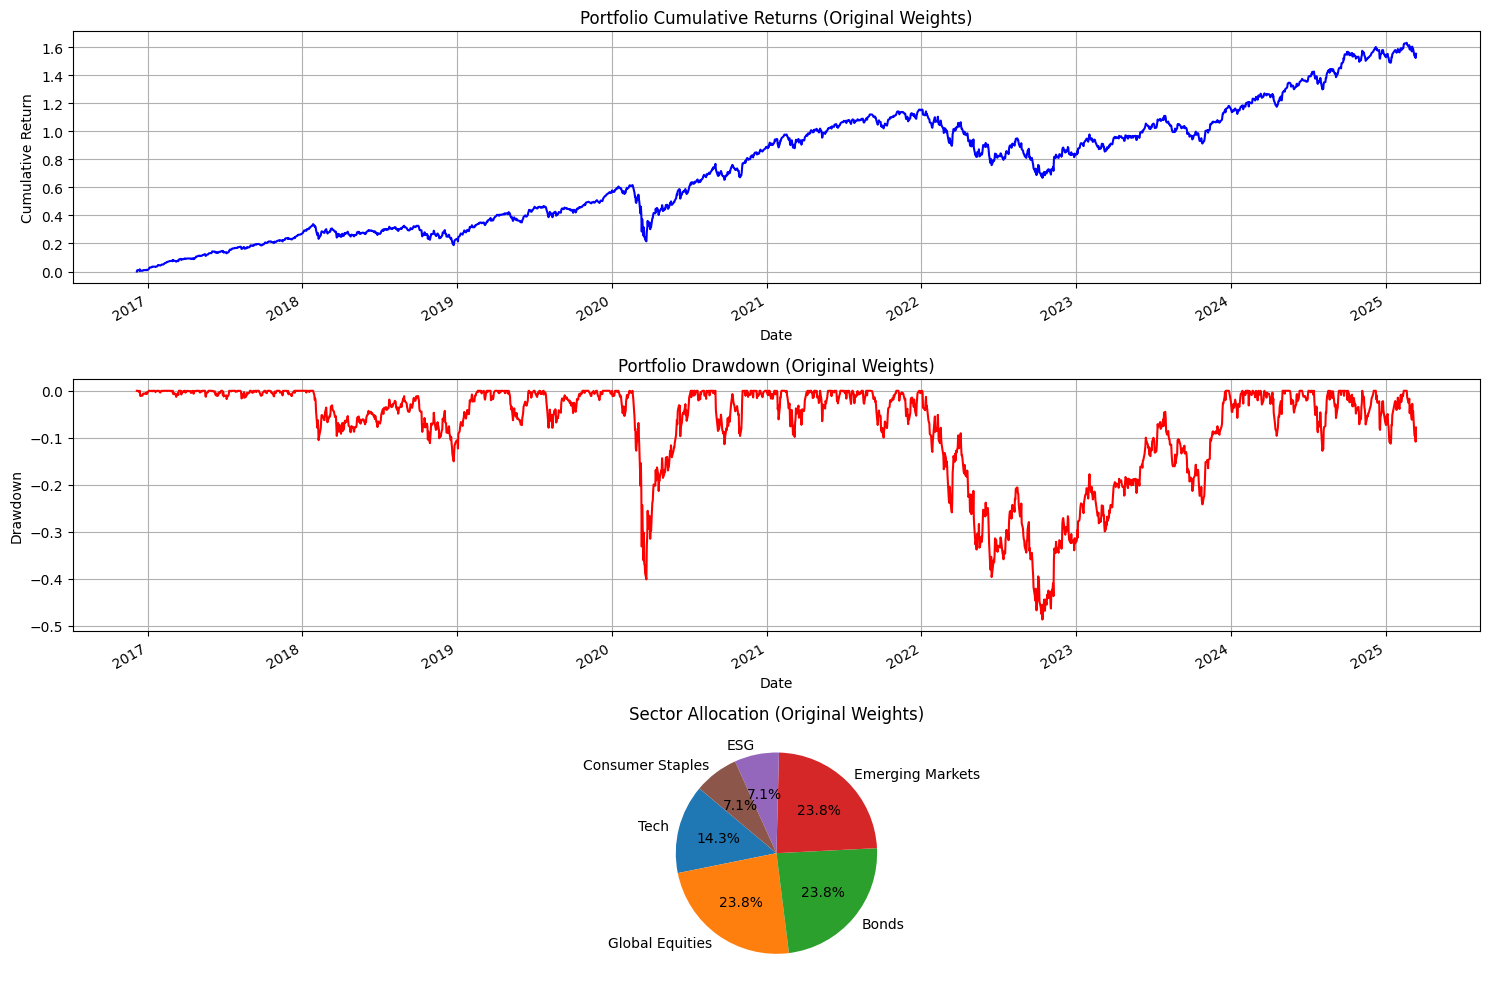

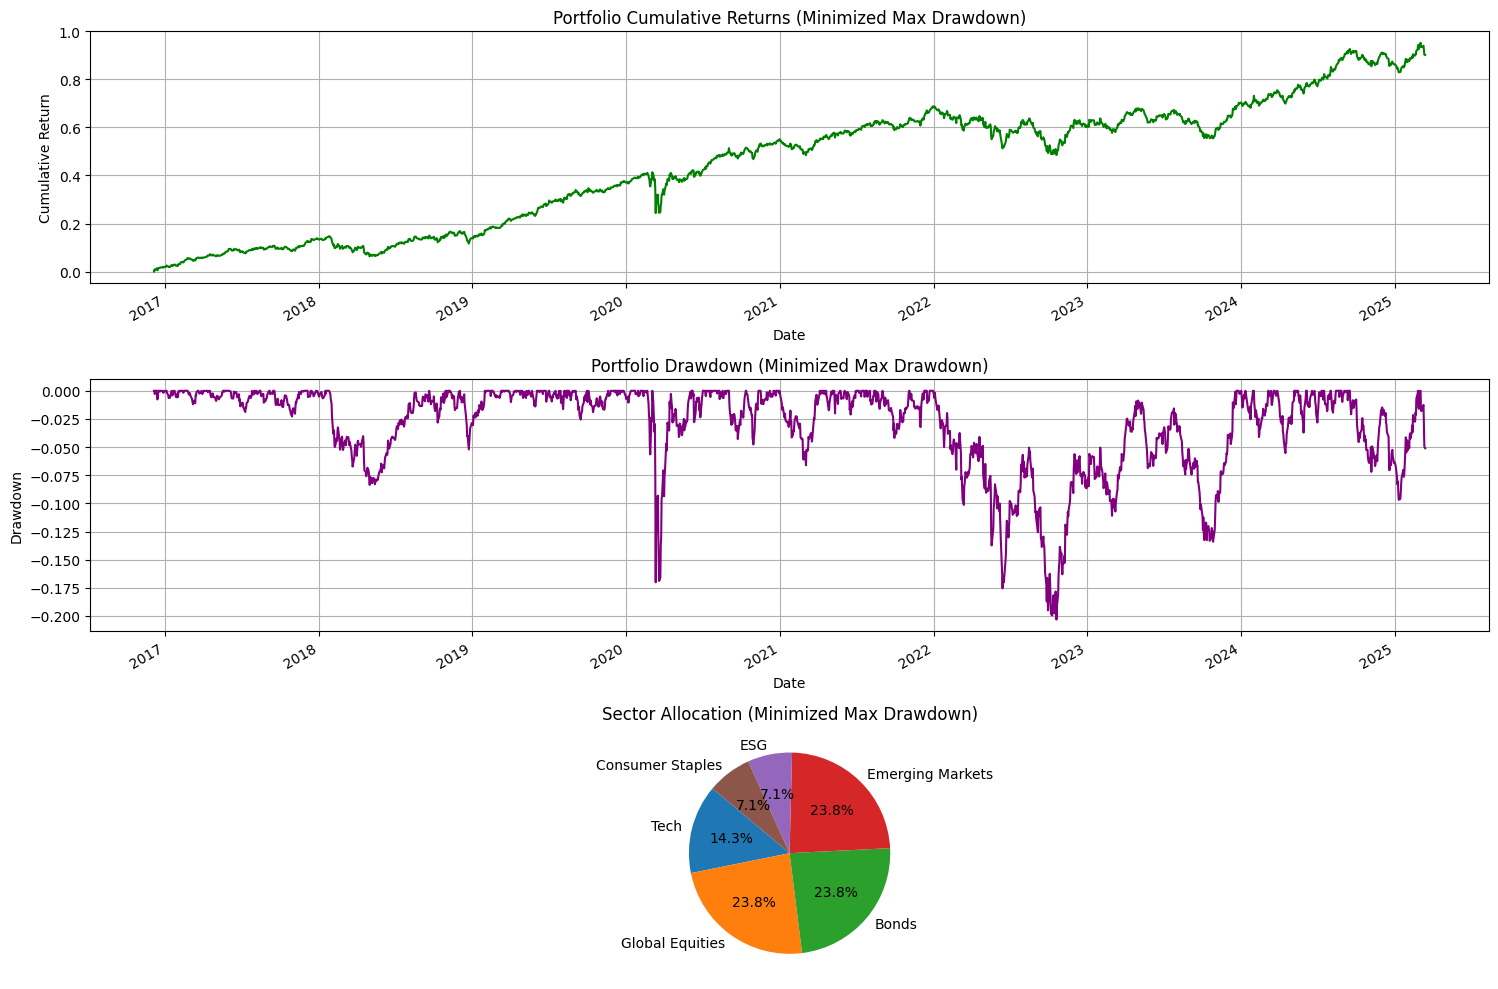

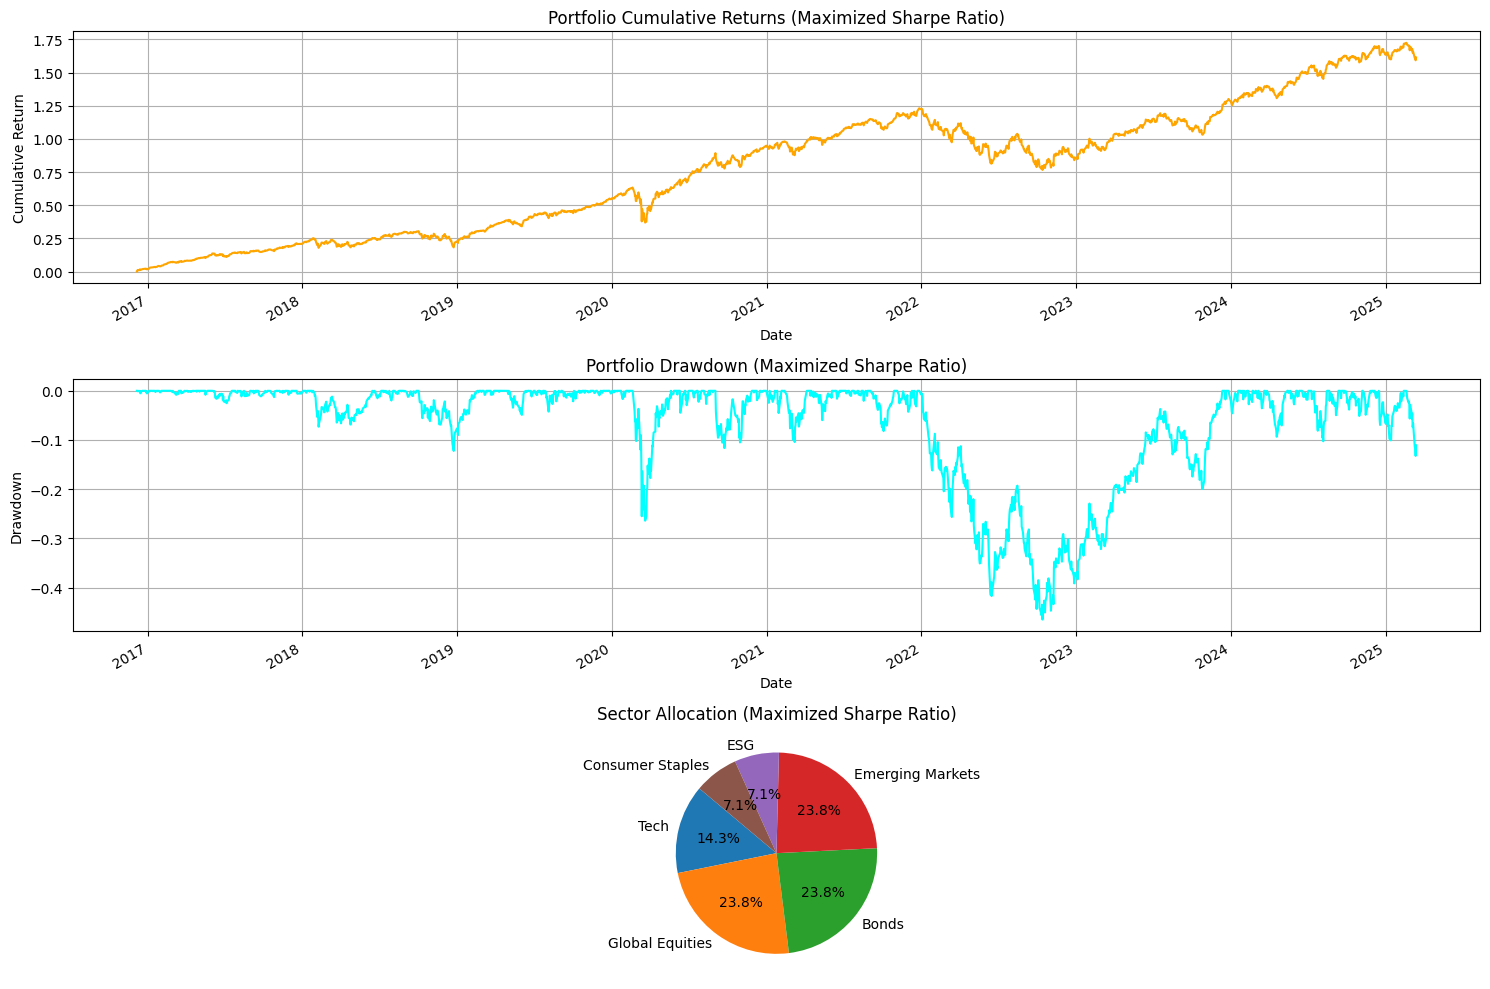

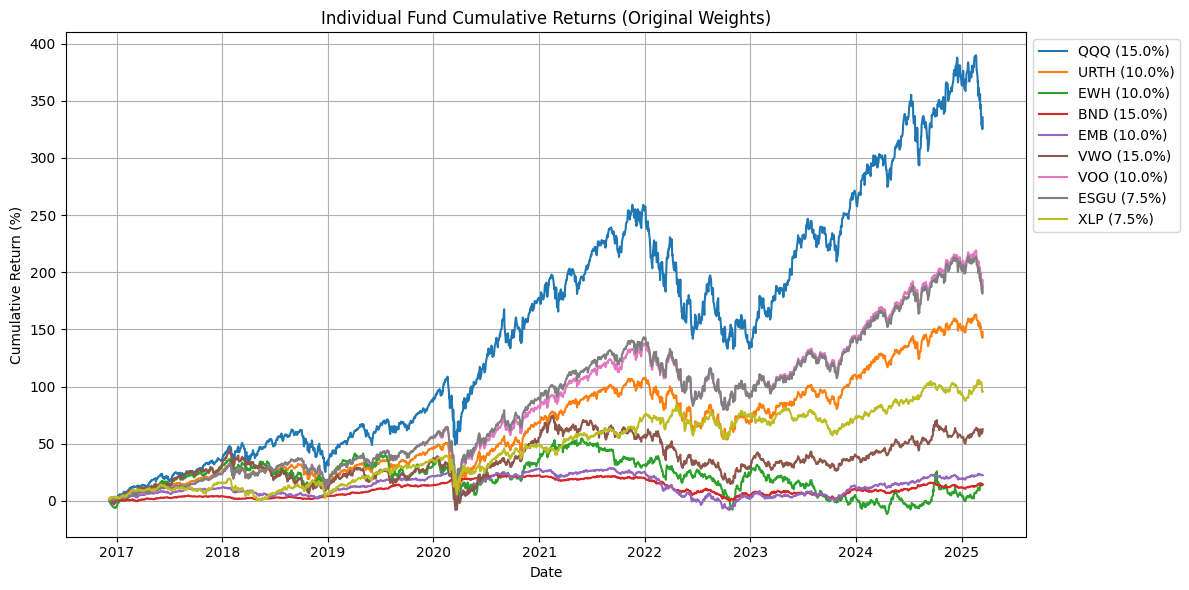

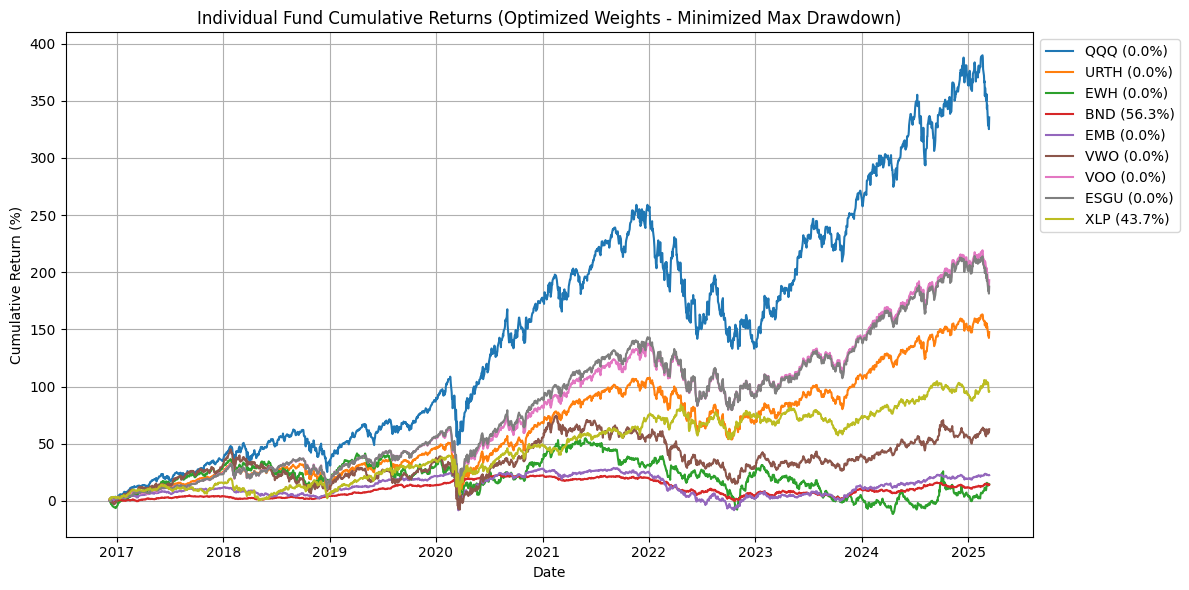

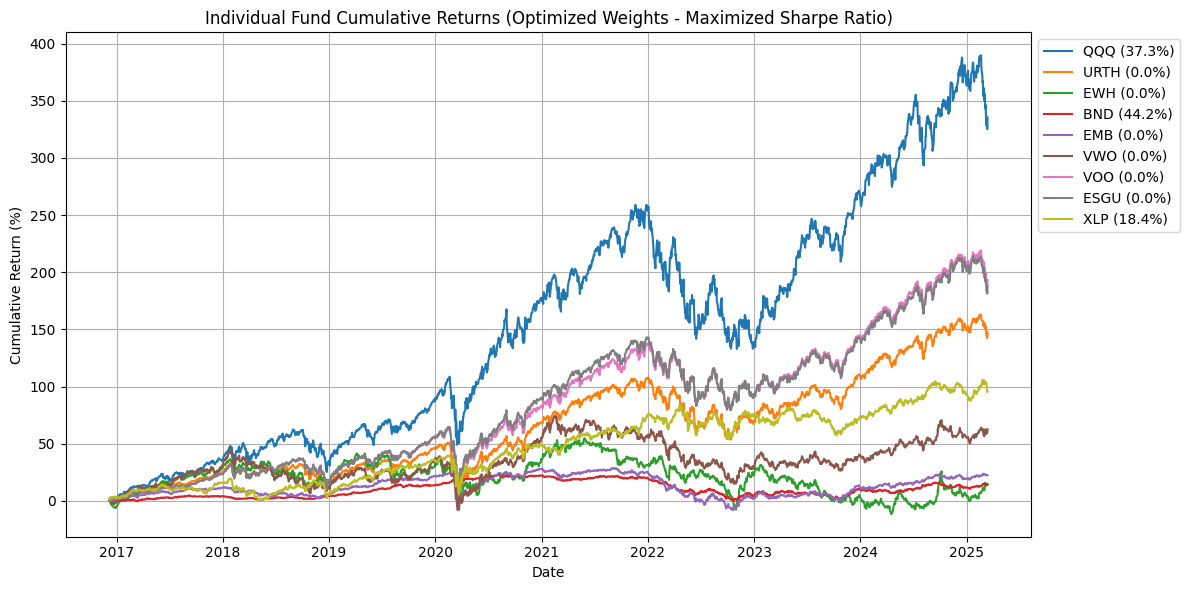

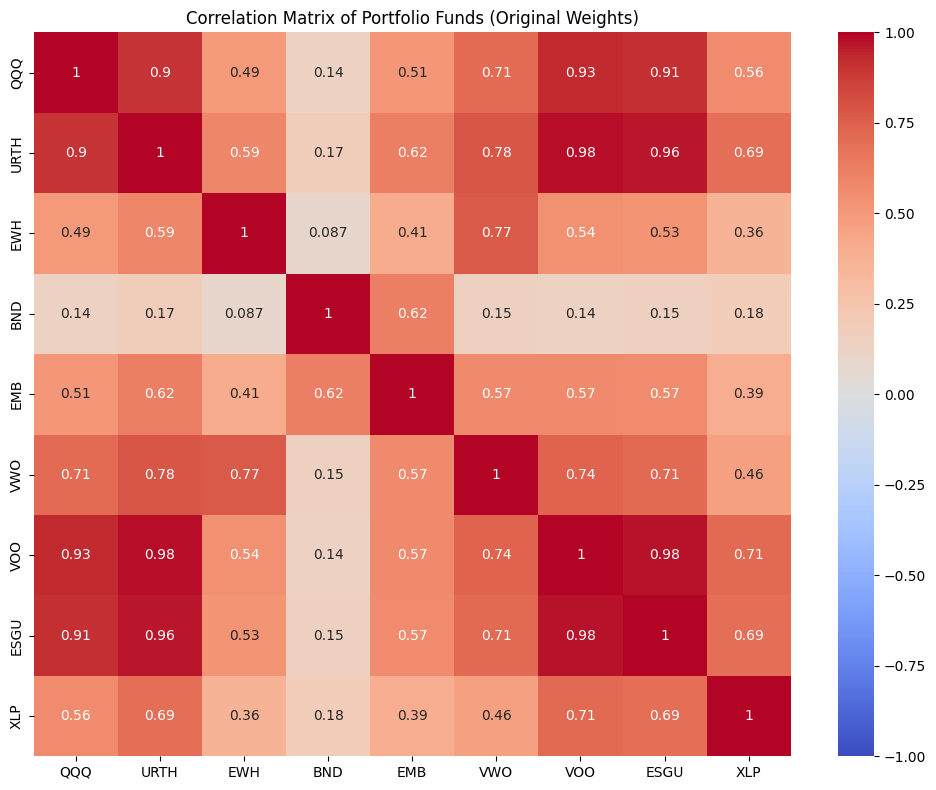

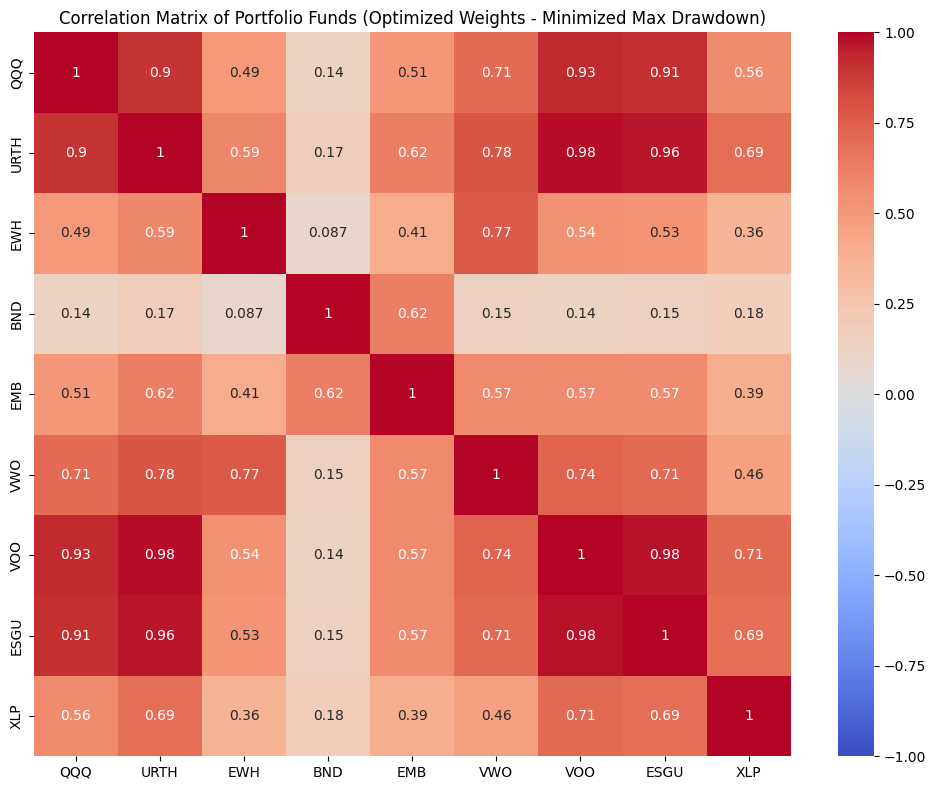

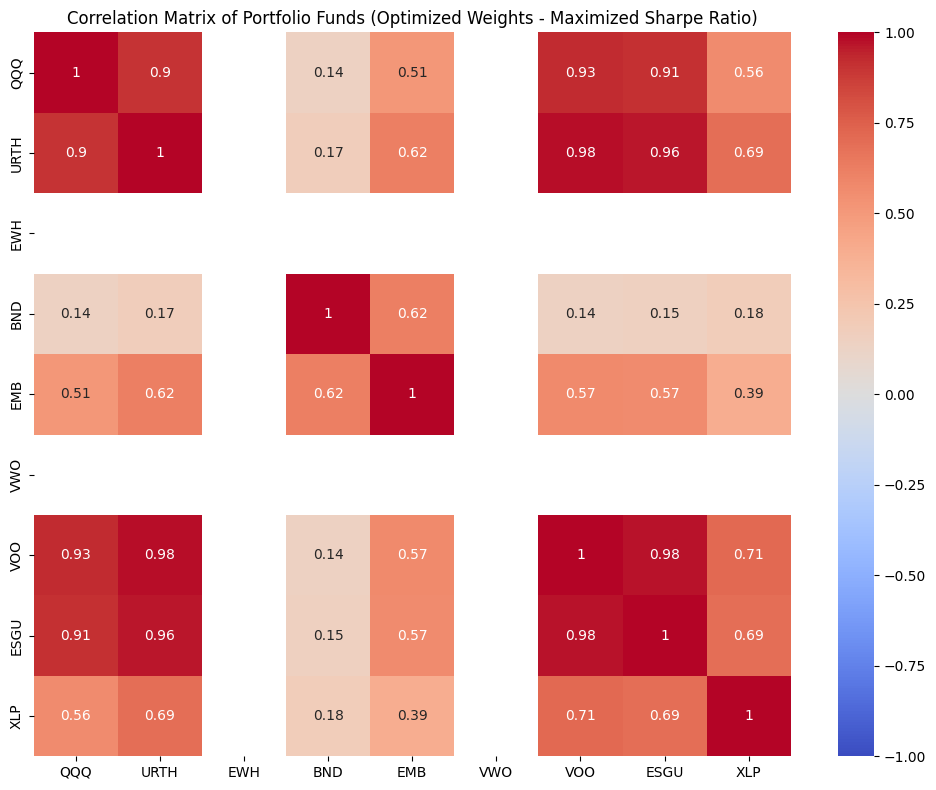

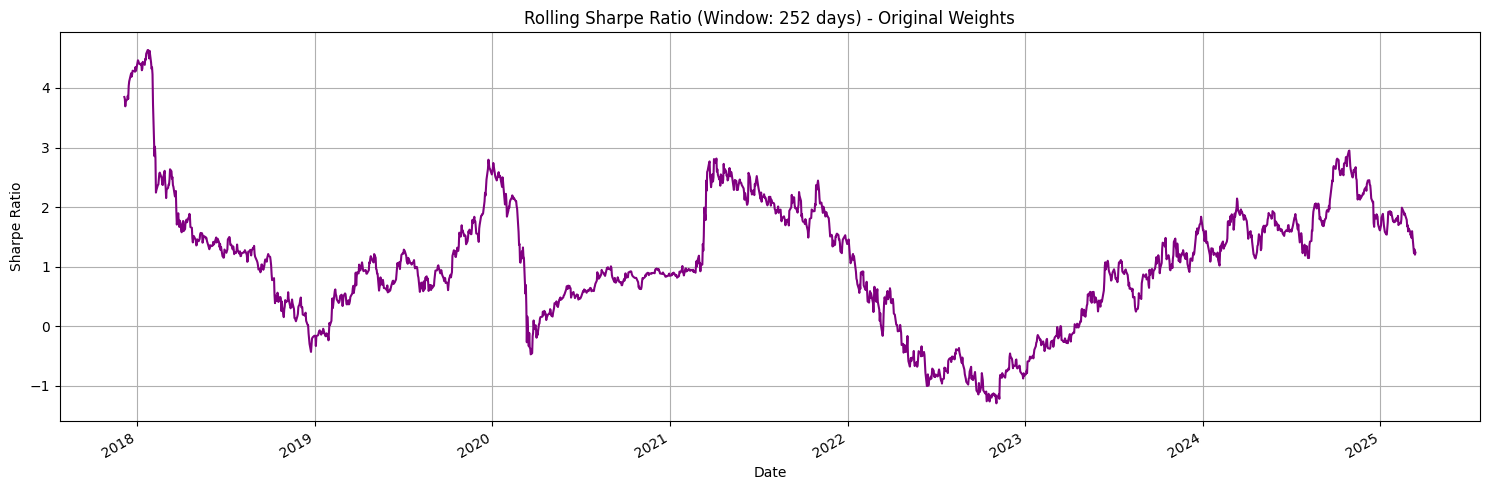

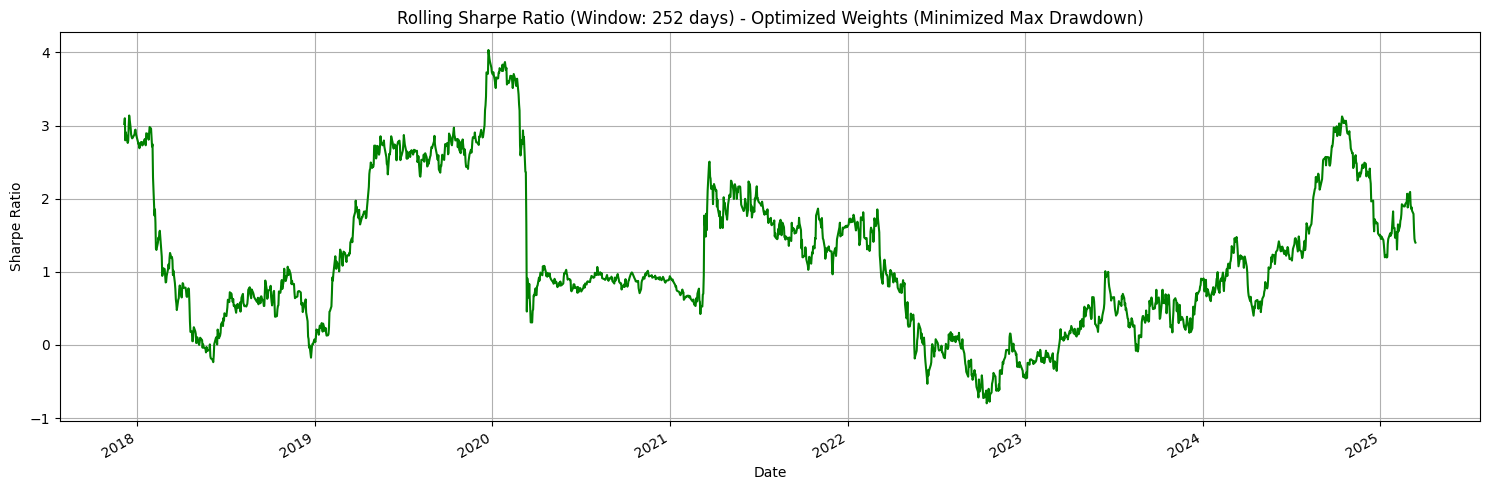

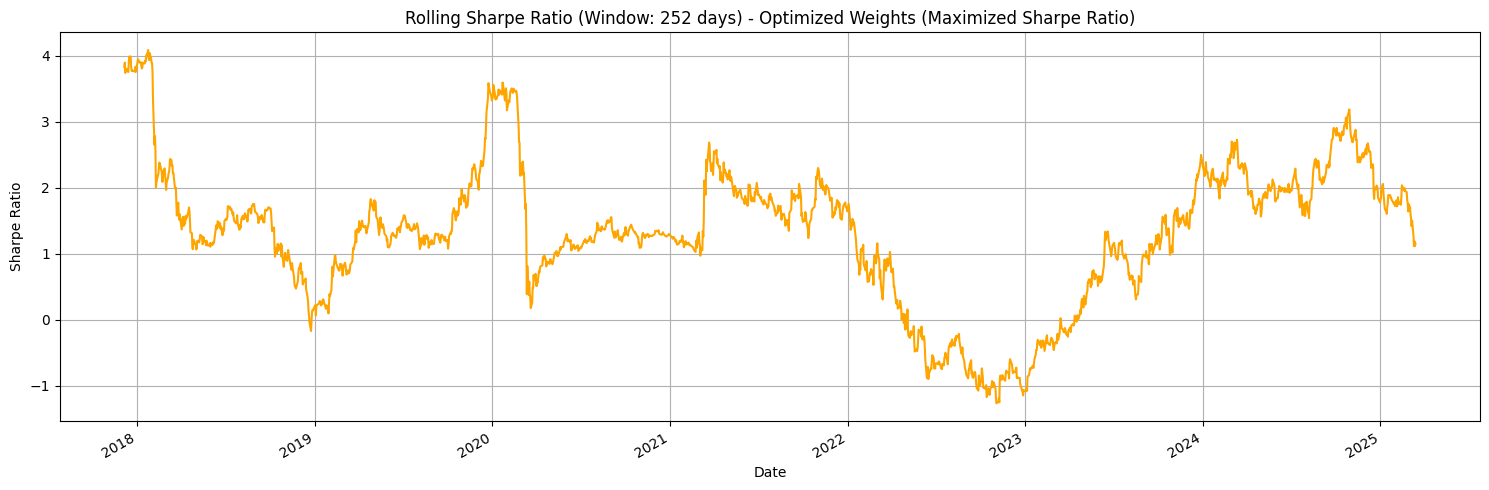

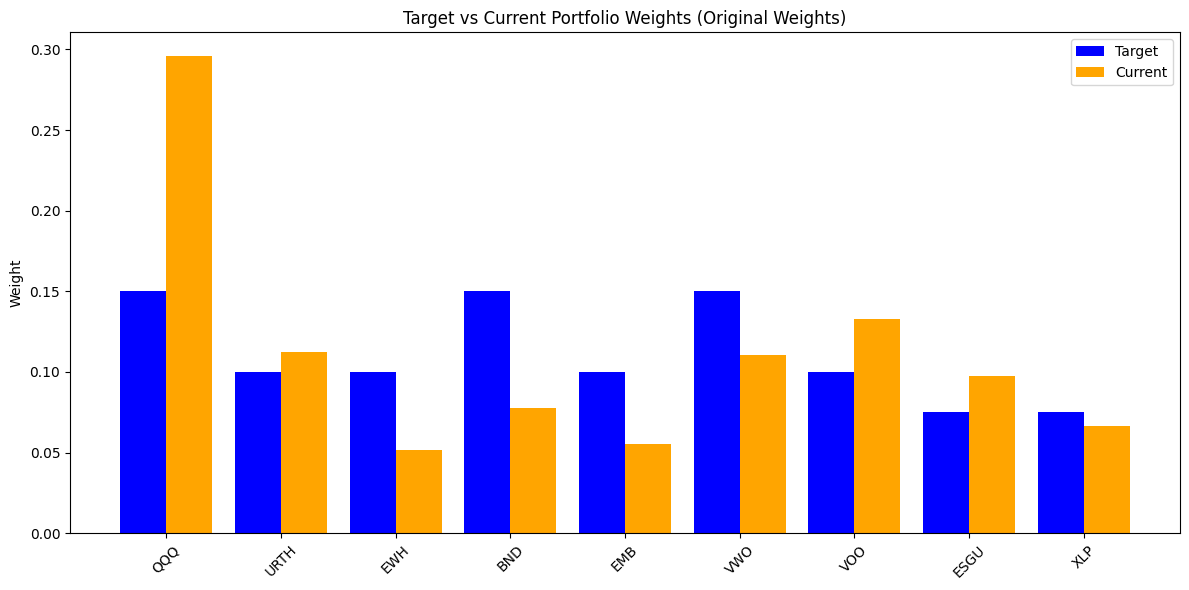

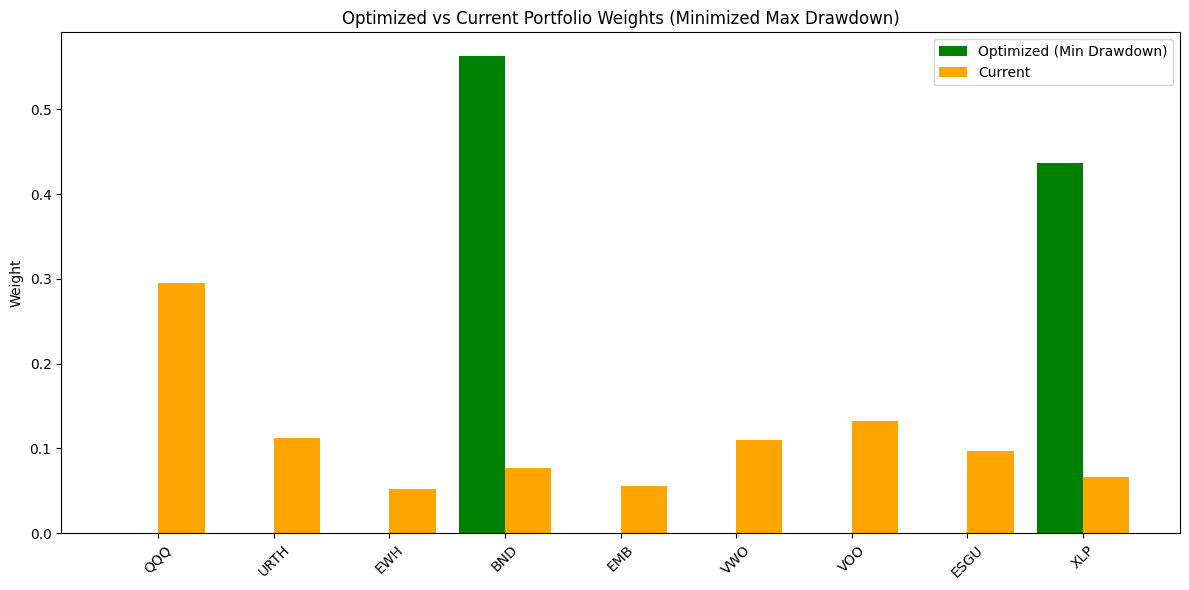

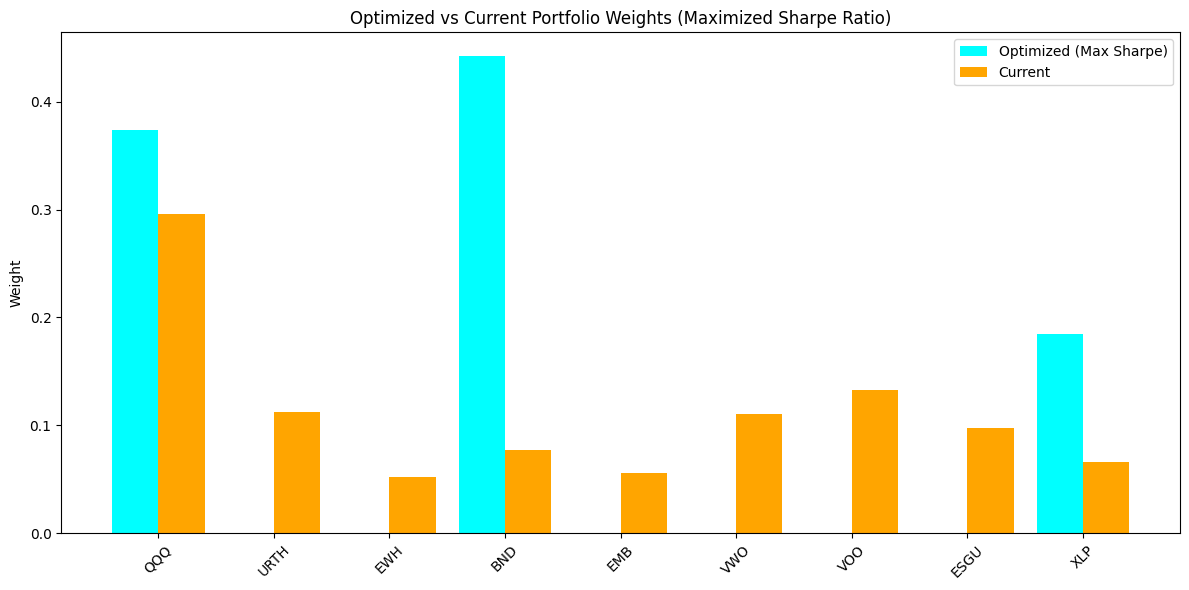


VOO return from 2016-12-06 to 2025-03-16: 193.05%


In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
from scipy.optimize import minimize

# Define the revised portfolio allocations
portfolio = {
    'QQQ': 0.15, 'URTH': 0.10, 'EWH': 0.10, 'BND': 0.15, 'EMB': 0.10, 'VWO': 0.15, 'VOO': 0.10,
    'ESGU': 0.075, 'XLP': 0.075
}

# Define expense ratios
expense_ratios = {
    'QQQ': 0.0020, 'URTH': 0.0024, 'EWH': 0.0050, 'BND': 0.00035, 'EMB': 0.0039, 'VWO': 0.0008,
    'VOO': 0.0003, 'ESGU': 0.0015, 'XLP': 0.0009
}

# Sector allocations
sector_allocations = {
    'Tech': 0.15, 'Global Equities': 0.25, 'Bonds': 0.25, 'Emerging Markets': 0.25,
    'ESG': 0.075, 'Consumer Staples': 0.075
}

valid_etf_tickers = ['QQQ', 'URTH', 'EWH', 'BND', 'EMB', 'VWO', 'VOO', 'ESGU', 'XLP']

# Scrape ETF data including dividends
def scrape_etf_data(tickers, start_date, end_date, max_retries=3):
    etf_prices = pd.DataFrame()
    etf_dividends = pd.DataFrame()
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')

    for ticker in tickers:
        for attempt in range(max_retries):
            try:
                ticker_obj = yf.Ticker(ticker)
                hist = ticker_obj.history(start=start_date_str, end=end_date_str, auto_adjust=True)
                prices = hist['Close']
                dividends = hist['Dividends']
                if not prices.empty:
                    etf_prices[ticker] = prices
                    etf_dividends[ticker] = dividends
                    print(f"Successfully scraped {ticker}: {len(prices)} days")
                    break
                else:
                    print(f"Empty data for {ticker} on attempt {attempt + 1}")
                    time.sleep(5 * (attempt + 1))
            except Exception as e:
                print(f"Attempt {attempt + 1} for {ticker} failed: {e}")
                time.sleep(5 * (attempt + 1))
        else:
            print(f"Max retries exceeded for {ticker}. Skipping.")

    etf_dividends = etf_dividends.fillna(0)
    return etf_prices.dropna(how='all'), etf_dividends

# Calculate performance metrics
def calculate_performance_metrics(daily_returns, risk_free_rate=0.03):
    if daily_returns.empty or len(daily_returns) == 0:
        return {metric: 0.0 for metric in ['Annualized Return (%)', 'Annualized Volatility (%)', 'Sharpe Ratio',
                                           'Sortino Ratio', 'Maximum Drawdown (%)', 'Calmar Ratio', 'VaR (95%) (%)']}

    annualized_return = daily_returns.mean() * 252 * 100
    annualized_volatility = daily_returns.std() * np.sqrt(252) * 100
    excess_returns = daily_returns - (risk_free_rate / 252)
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252) if excess_returns.std() != 0 else 0
    downside_returns = daily_returns[daily_returns < 0]
    downside_volatility = downside_returns.std() * np.sqrt(252) if not downside_returns.empty else 0
    sortino_ratio = (annualized_return / 100 - risk_free_rate) / downside_volatility if downside_volatility != 0 else 0
    cumulative_returns = (1 + daily_returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min() * 100 if not drawdown.empty else 0
    calmar_ratio = (annualized_return / 100) / abs(max_drawdown / 100) if max_drawdown != 0 else 0
    var_95 = np.percentile(daily_returns.dropna(), 5) * 100 if not daily_returns.empty else 0
    return {
        'Annualized Return (%)': annualized_return, 'Annualized Volatility (%)': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio, 'Sortino Ratio': sortino_ratio, 'Maximum Drawdown (%)': max_drawdown,
        'Calmar Ratio': calmar_ratio, 'VaR (95%) (%)': var_95
    }

# Objective function for minimizing drawdown
def objective_drawdown(weights, daily_returns):
    portfolio_returns = (daily_returns * weights).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    return -drawdown.min()  # Minimize max drawdown (negative for minimization)

# Constraint for minimum return
def return_constraint(weights, daily_returns, min_return=0.05):  # 5% annualized
    portfolio_returns = (daily_returns * weights).sum(axis=1)
    annualized_return = portfolio_returns.mean() * 252
    return annualized_return - min_return  # Must be >= 0

# Optimize allocation to minimize drawdown
def optimize_allocation_drawdown(daily_returns, min_return=5.0):
    daily_returns_clean = daily_returns.dropna()
    if daily_returns_clean.empty:
        print("Error: No valid data after cleaning NaNs.")
        return pd.Series([1/len(daily_returns.columns)] * len(daily_returns.columns), index=daily_returns.columns)

    initial_weights = np.array(list(portfolio.values()))
    bounds = [(0, 1)] * len(initial_weights)  # Weights between 0 and 1
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Sum to 1
        {'type': 'ineq', 'fun': lambda w: return_constraint(w, daily_returns_clean, min_return / 100)}
    ]

    result = minimize(
        objective_drawdown,
        initial_weights,
        args=(daily_returns_clean,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'disp': False}
    )

    if not result.success:
        print("Warning: Drawdown optimization failed:", result.message)

    optimized_weights = pd.Series(result.x, index=daily_returns_clean.columns)
    print("\nOptimized Allocation (Minimized Maximum Drawdown with Return >= 5%):")
    for ticker, weight in optimized_weights.items():
        print(f"{ticker}: {weight*100:.2f}%")
    return optimized_weights

# Objective function for maximizing Sharpe (minimize negative Sharpe)
def objective_sharpe(weights, daily_returns, risk_free_rate=0.03):
    portfolio_returns = (daily_returns * weights).sum(axis=1)
    mean_return = portfolio_returns.mean() * 252
    volatility = portfolio_returns.std() * np.sqrt(252)
    sharpe = (mean_return - risk_free_rate) / volatility if volatility != 0 else 0
    return -sharpe  # Minimize negative Sharpe to maximize Sharpe

# Constraint for max drawdown
def drawdown_constraint(weights, daily_returns, max_drawdown_limit=50.0):
    portfolio_returns = (daily_returns * weights).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min() * 100
    return max_drawdown_limit + max_drawdown  # Must be >= 0 (i.e., drawdown <= -50%)

# Optimize allocation to maximize Sharpe
def optimize_allocation_sharpe(daily_returns, risk_free_rate=0.03, max_drawdown_limit=50.0):
    daily_returns_clean = daily_returns.dropna()
    if daily_returns_clean.empty:
        print("Error: No valid data after cleaning NaNs.")
        return pd.Series([1/len(daily_returns.columns)] * len(daily_returns.columns), index=daily_returns.columns)

    initial_weights = np.array(list(portfolio.values()))
    bounds = [(0, 1)] * len(initial_weights)  # Weights between 0 and 1
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Sum to 1
        {'type': 'ineq', 'fun': lambda w: drawdown_constraint(w, daily_returns_clean, max_drawdown_limit)}
    ]

    result = minimize(
        objective_sharpe,
        initial_weights,
        args=(daily_returns_clean, risk_free_rate),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'disp': False}
    )

    if not result.success:
        print("Warning: Sharpe optimization failed:", result.message)

    optimized_weights = pd.Series(result.x, index=daily_returns_clean.columns)
    print("\nOptimized Allocation (Maximized Sharpe Ratio with Max Drawdown <= 50%):")
    for ticker, weight in optimized_weights.items():
        print(f"{ticker}: {weight*100:.2f}%")
    return optimized_weights

# Visualization functions (unchanged, omitted for brevity)
def visualize_performance(cumulative_returns_orig, drawdown_orig, cumulative_returns_drawdown, drawdown_drawdown,
                         cumulative_returns_sharpe, drawdown_sharpe, sector_allocations):
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 1, 1)
    cumulative_returns_orig.plot(title='Portfolio Cumulative Returns (Original Weights)', color='blue')
    plt.ylabel('Cumulative Return')
    plt.grid()
    plt.subplot(3, 1, 2)
    drawdown_orig.plot(title='Portfolio Drawdown (Original Weights)', color='red')
    plt.ylabel('Drawdown')
    plt.grid()
    plt.subplot(3, 1, 3)
    plt.pie(sector_allocations.values(), labels=sector_allocations.keys(), autopct='%1.1f%%', startangle=140)
    plt.title('Sector Allocation (Original Weights)')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.subplot(3, 1, 1)
    cumulative_returns_drawdown.plot(title='Portfolio Cumulative Returns (Minimized Max Drawdown)', color='green')
    plt.ylabel('Cumulative Return')
    plt.grid()
    plt.subplot(3, 1, 2)
    drawdown_drawdown.plot(title='Portfolio Drawdown (Minimized Max Drawdown)', color='purple')
    plt.ylabel('Drawdown')
    plt.grid()
    plt.subplot(3, 1, 3)
    plt.pie(sector_allocations.values(), labels=sector_allocations.keys(), autopct='%1.1f%%', startangle=140)
    plt.title('Sector Allocation (Minimized Max Drawdown)')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.subplot(3, 1, 1)
    cumulative_returns_sharpe.plot(title='Portfolio Cumulative Returns (Maximized Sharpe Ratio)', color='orange')
    plt.ylabel('Cumulative Return')
    plt.grid()
    plt.subplot(3, 1, 2)
    drawdown_sharpe.plot(title='Portfolio Drawdown (Maximized Sharpe Ratio)', color='cyan')
    plt.ylabel('Drawdown')
    plt.grid()
    plt.subplot(3, 1, 3)
    plt.pie(sector_allocations.values(), labels=sector_allocations.keys(), autopct='%1.1f%%', startangle=140)
    plt.title('Sector Allocation (Maximized Sharpe Ratio)')
    plt.tight_layout()
    plt.show()

def visualize_individual_returns(all_data, portfolio_weights, optimized_weights_drawdown, optimized_weights_sharpe):
    cumulative_returns = (1 + all_data.pct_change().dropna()).cumprod() - 1
    for weights, title, color in [
        (portfolio_weights, 'Original Weights', 'blue'),
        (optimized_weights_drawdown, 'Optimized Weights - Minimized Max Drawdown', 'green'),
        (optimized_weights_sharpe, 'Optimized Weights - Maximized Sharpe Ratio', 'orange')
    ]:
        plt.figure(figsize=(12, 6))
        for ticker in cumulative_returns.columns:
            plt.plot(cumulative_returns.index, cumulative_returns[ticker] * 100, label=f"{ticker} ({weights[ticker]*100:.1f}%)")
        plt.title(f'Individual Fund Cumulative Returns ({title})')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return (%)')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid()
        plt.tight_layout()
        plt.show()

def visualize_correlation_heatmap(daily_returns, portfolio_weights, optimized_weights_drawdown, optimized_weights_sharpe):
    for weights, title in [
        (portfolio_weights, 'Original Weights'),
        (optimized_weights_drawdown, 'Optimized Weights - Minimized Max Drawdown'),
        (optimized_weights_sharpe, 'Optimized Weights - Maximized Sharpe Ratio')
    ]:
        weighted_returns = daily_returns * weights
        plt.figure(figsize=(10, 8))
        sns.heatmap(weighted_returns.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title(f'Correlation Matrix of Portfolio Funds ({title})')
        plt.tight_layout()
        plt.show()

def visualize_rolling_sharpe(portfolio_returns_orig, portfolio_returns_drawdown, portfolio_returns_sharpe, window=252):
    for returns, title, color in [
        (portfolio_returns_orig, 'Original Weights', 'purple'),
        (portfolio_returns_drawdown, 'Optimized Weights (Minimized Max Drawdown)', 'green'),
        (portfolio_returns_sharpe, 'Optimized Weights (Maximized Sharpe Ratio)', 'orange')
    ]:
        rolling_mean = returns.rolling(window).mean() * 252
        rolling_std = returns.rolling(window).std() * np.sqrt(252)
        rolling_sharpe = rolling_mean / rolling_std
        plt.figure(figsize=(15, 5))
        rolling_sharpe.plot(title=f'Rolling Sharpe Ratio (Window: {window} days) - {title}', color=color)
        plt.ylabel('Sharpe Ratio')
        plt.grid()
        plt.tight_layout()
        plt.show()

def visualize_allocation_vs_current(current_weights, portfolio, optimized_weights_drawdown, optimized_weights_sharpe):
    tickers = list(portfolio.keys())
    target_weights = [portfolio[ticker] for ticker in tickers]
    current_weights_list = [current_weights.get(ticker, 0) for ticker in tickers]
    optimized_weights_drawdown_list = [optimized_weights_drawdown[ticker] for ticker in tickers]
    optimized_weights_sharpe_list = [optimized_weights_sharpe[ticker] for ticker in tickers]

    x = np.arange(len(tickers))
    plt.figure(figsize=(12, 6))
    plt.bar(x - 0.2, target_weights, 0.4, label='Target', color='blue')
    plt.bar(x + 0.2, current_weights_list, 0.4, label='Current', color='orange')
    plt.xticks(x, tickers, rotation=45)
    plt.title('Target vs Current Portfolio Weights (Original Weights)')
    plt.ylabel('Weight')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.bar(x - 0.2, optimized_weights_drawdown_list, 0.4, label='Optimized (Min Drawdown)', color='green')
    plt.bar(x + 0.2, current_weights_list, 0.4, label='Current', color='orange')
    plt.xticks(x, tickers, rotation=45)
    plt.title('Optimized vs Current Portfolio Weights (Minimized Max Drawdown)')
    plt.ylabel('Weight')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.bar(x - 0.2, optimized_weights_sharpe_list, 0.4, label='Optimized (Max Sharpe)', color='cyan')
    plt.bar(x + 0.2, current_weights_list, 0.4, label='Current', color='orange')
    plt.xticks(x, tickers, rotation=45)
    plt.title('Optimized vs Current Portfolio Weights (Maximized Sharpe Ratio)')
    plt.ylabel('Weight')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365 * 15)

    # Scrape ETF data
    all_prices, all_dividends = scrape_etf_data(valid_etf_tickers, start_date, end_date)
    if all_prices.empty:
        print("Failed to retrieve ETF data. Exiting.")
        exit()

    all_prices = all_prices.dropna()
    all_dividends = all_dividends.reindex(all_prices.index).fillna(0)
    print(f"All data columns: {list(all_prices.columns)}")
    print("First few rows of price data:\n", all_prices.head())
    print("First few rows of dividend data:\n", all_dividends.head())

    # Calculate total daily returns
    price_returns = all_prices.pct_change().dropna()
    dividend_returns = all_dividends.div(all_prices.shift(1)).fillna(0)
    daily_returns = price_returns + dividend_returns
    for ticker in daily_returns.columns:
        if ticker in expense_ratios:
            daily_returns[ticker] -= expense_ratios[ticker] / 252

    print("Daily returns before cleaning:\n", daily_returns.head())
    print("NaN count in daily_returns:", daily_returns.isna().sum().sum())

    # Calculate portfolio returns
    portfolio_weights = pd.Series(portfolio)
    portfolio_returns_orig = (daily_returns * portfolio_weights).sum(axis=1)
    optimized_weights_drawdown = optimize_allocation_drawdown(daily_returns, min_return=5.0)
    portfolio_returns_drawdown = (daily_returns * optimized_weights_drawdown).sum(axis=1)
    optimized_weights_sharpe = optimize_allocation_sharpe(daily_returns, max_drawdown_limit=50.0)
    portfolio_returns_sharpe = (daily_returns * optimized_weights_sharpe).sum(axis=1)

    # Rebalancing check
    initial_prices = all_prices.iloc[0]
    current_prices = all_prices.iloc[-1]
    initial_portfolio_value = 1000000
    initial_shares = {ticker: (portfolio[ticker] * initial_portfolio_value) / initial_prices[ticker]
                      for ticker in portfolio.keys()}
    current_value = sum(initial_shares[ticker] * current_prices[ticker] for ticker in portfolio.keys())
    current_weights = {ticker: (initial_shares[ticker] * current_prices[ticker]) / current_value
                       for ticker in portfolio.keys()}
    print("\nRebalancing Check:")
    for ticker in portfolio.keys():
        drift = abs(current_weights[ticker] - portfolio[ticker])
        if drift > 0.05:
            print(f"Rebalance needed for {ticker}: Current {current_weights[ticker]*100:.2f}%, Target {portfolio[ticker]*100:.2f}% (Drift: {drift*100:.2f}%)")
        else:
            print(f"{ticker}: Current {current_weights[ticker]*100:.2f}%, Target {portfolio[ticker]*100:.2f}% (Within tolerance)")

    # Calculate and print performance metrics
    metrics_orig = calculate_performance_metrics(portfolio_returns_orig)
    print("\nPortfolio Performance Metrics (Original Weights):")
    for metric, value in metrics_orig.items():
        print(f"{metric}: {value:.2f}")

    metrics_drawdown = calculate_performance_metrics(portfolio_returns_drawdown)
    print("\nPortfolio Performance Metrics (Minimized Max Drawdown with Return >= 5%):")
    for metric, value in metrics_drawdown.items():
        print(f"{metric}: {value:.2f}")

    metrics_sharpe = calculate_performance_metrics(portfolio_returns_sharpe)
    print("\nPortfolio Performance Metrics (Maximized Sharpe Ratio with Max Drawdown <= 50%):")
    for metric, value in metrics_sharpe.items():
        print(f"{metric}: {value:.2f}")

    # Cumulative returns and drawdowns
    cumulative_returns_orig = (1 + portfolio_returns_orig).cumprod() - 1
    drawdown_orig = cumulative_returns_orig - cumulative_returns_orig.cummax()
    cumulative_returns_drawdown = (1 + portfolio_returns_drawdown).cumprod() - 1
    drawdown_drawdown = cumulative_returns_drawdown - cumulative_returns_drawdown.cummax()
    cumulative_returns_sharpe = (1 + portfolio_returns_sharpe).cumprod() - 1
    drawdown_sharpe = cumulative_returns_sharpe - cumulative_returns_sharpe.cummax()

    # Visualizations
    visualize_performance(cumulative_returns_orig, drawdown_orig, cumulative_returns_drawdown, drawdown_drawdown,
                         cumulative_returns_sharpe, drawdown_sharpe, sector_allocations)
    visualize_individual_returns(all_prices, portfolio_weights, optimized_weights_drawdown, optimized_weights_sharpe)
    visualize_correlation_heatmap(daily_returns, portfolio_weights, optimized_weights_drawdown, optimized_weights_sharpe)
    visualize_rolling_sharpe(portfolio_returns_orig, portfolio_returns_drawdown, portfolio_returns_sharpe)
    visualize_allocation_vs_current(current_weights, portfolio, optimized_weights_drawdown, optimized_weights_sharpe)

    # Validate period return
    start_date_common = all_prices.index[0].date()
    if 'VOO' in all_prices.columns:
        voo_start = all_prices['VOO'].iloc[0]
        voo_end = all_prices['VOO'].iloc[-1]
        voo_return_period = ((voo_end / voo_start) - 1) * 100
        print(f"\nVOO return from {start_date_common} to {end_date.date()}: {voo_return_period:.2f}%")

Risk Man

[*********************100%***********************]  9 of 9 completed


ETF data retrieved successfully on attempt 1. Tickers: ['BND', 'EMB', 'ESGU', 'EWH', 'QQQ', 'URTH', 'VOO', 'VWO', 'XLP']
ETF data columns: ['BND', 'EMB', 'ESGU', 'EWH', 'QQQ', 'URTH', 'VOO', 'VWO', 'XLP']
Fund data columns: []
All data columns after concat: ['BND', 'EMB', 'ESGU', 'EWH', 'QQQ', 'URTH', 'VOO', 'VWO', 'XLP']
Daily returns columns: ['BND', 'EMB', 'ESGU', 'EWH', 'QQQ', 'URTH', 'VOO', 'VWO', 'XLP']
Portfolio weights: {'QQQ': 0.15, 'URTH': 0.1, 'EWH': 0.1, 'BND': 0.15, 'EMB': 0.1, 'VWO': 0.15, 'VOO': 0.1, 'ESGU': 0.075, 'XLP': 0.075}
Available tickers for rebalancing: ['BND', 'EMB', 'EWH', 'QQQ', 'URTH', 'VOO', 'VWO', 'XLP']

Rebalancing Check:
Rebalance needed for BND: Current weight 8.25%, Target 15.00% (Drift: 6.75%)
EMB: Current weight 6.26%, Target 10.00% (Within tolerance)
EWH: Current weight 5.51%, Target 10.00% (Within tolerance)
Rebalance needed for QQQ: Current weight 34.14%, Target 15.00% (Drift: 19.14%)
URTH: Current weight 12.03%, Target 10.00% (Within tolerance)

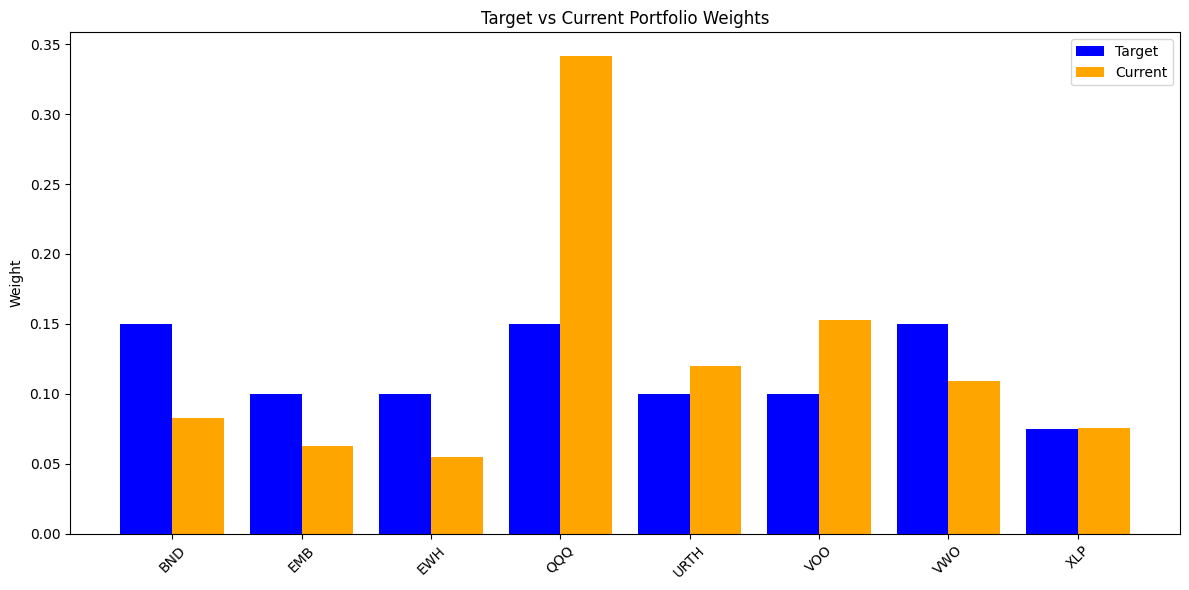


Optimized Allocation (Minimized Maximum Drawdown):
BND: 49.13%
EMB: 0.00%
ESGU: 0.00%
EWH: 0.00%
QQQ: 0.00%
URTH: 0.00%
VOO: 0.00%
VWO: 0.00%
XLP: 50.87%

Portfolio Risk Metrics as of 2025-03-16 02:54:20.461552 (Original Weights)
Historical VaR (95%) (%): -1.24
Historical CVaR (95%) (%): -2.02
Monte Carlo VaR (95%) (1-year) (%): -13.27
Monte Carlo CVaR (95%) (1-year) (%): -17.81


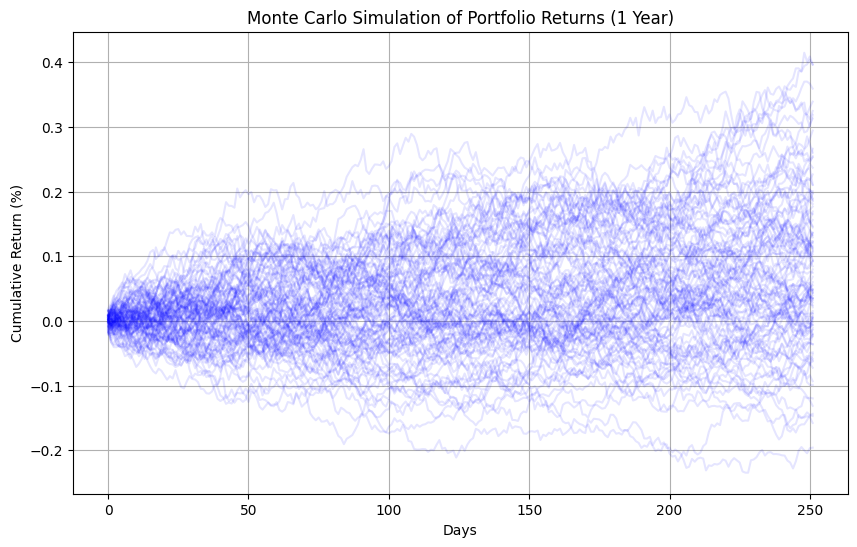

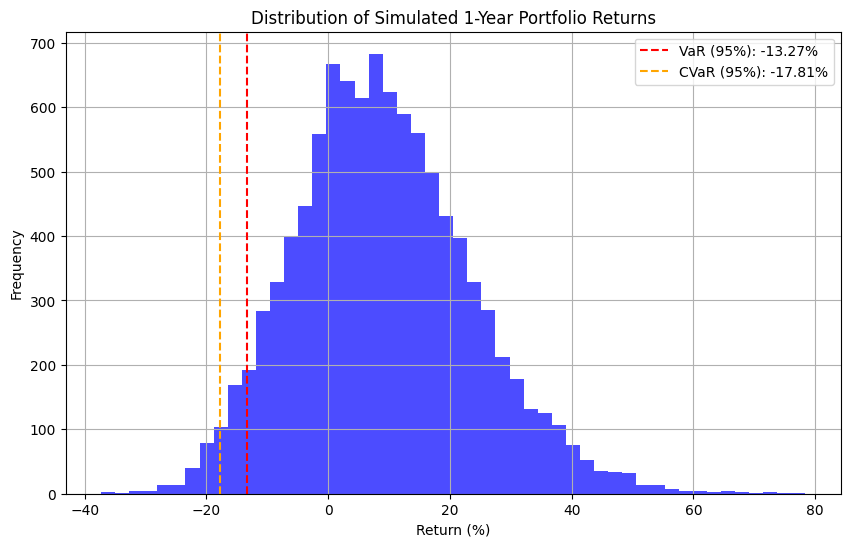

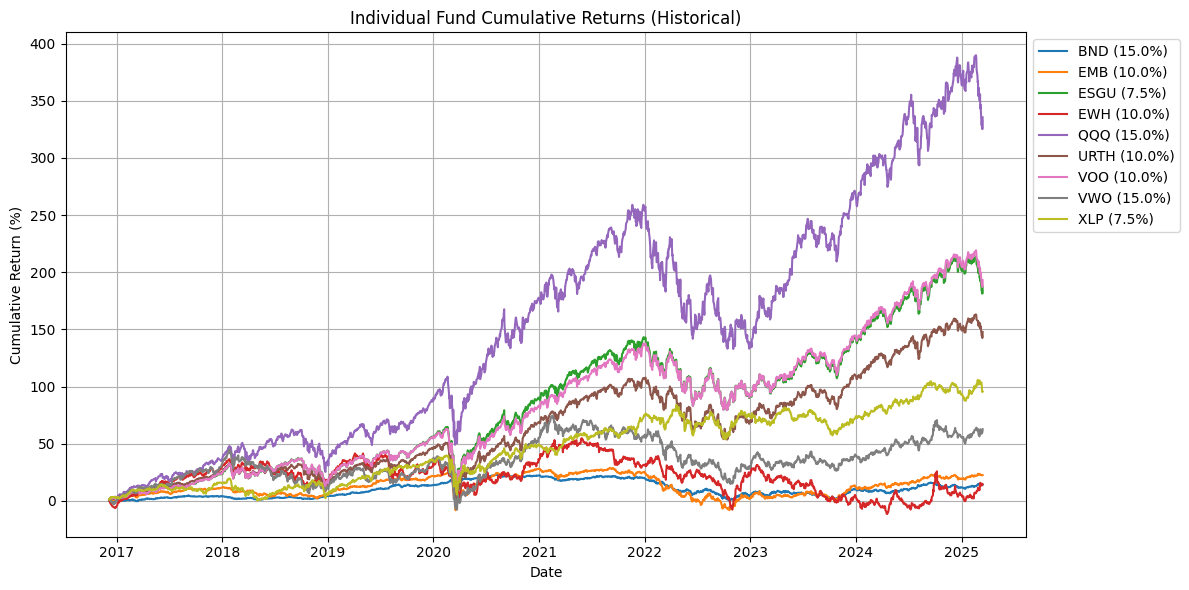

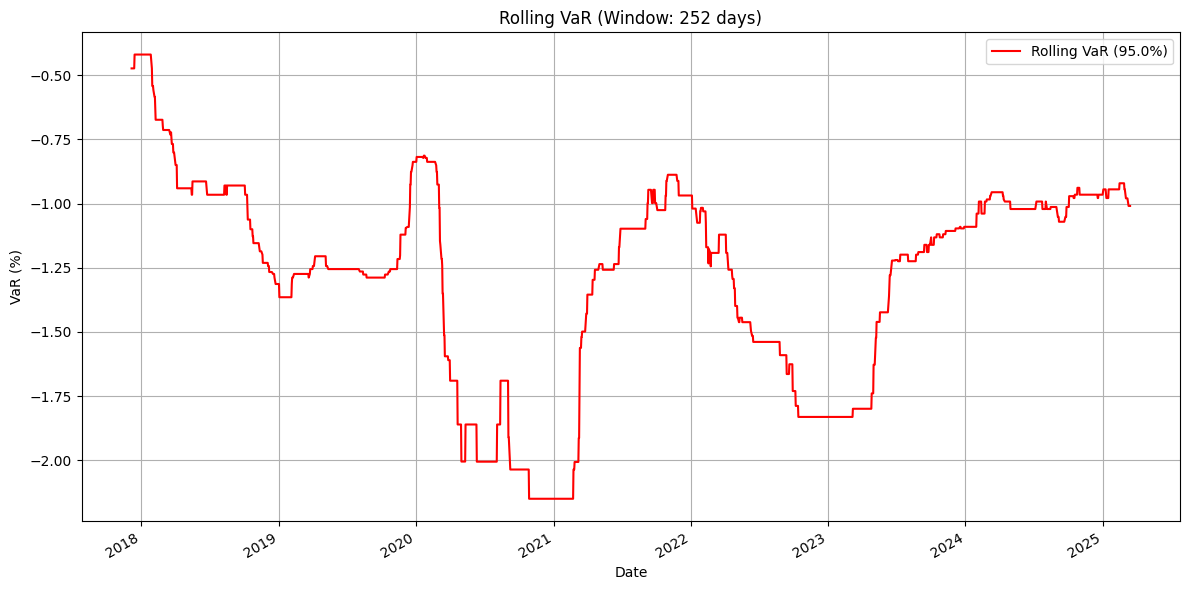

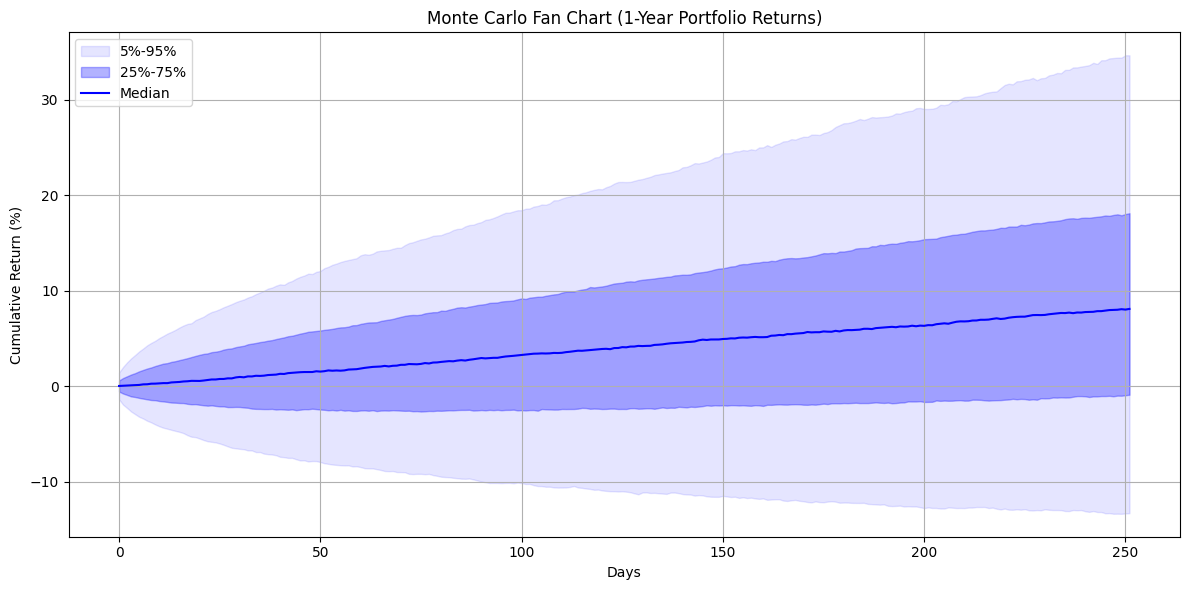

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

# Define the original portfolio allocations
portfolio = {
    'QQQ': 0.15, 'URTH': 0.10, 'EWH': 0.10, 'BND': 0.15, 'EMB': 0.10,
    'VWO': 0.15, 'VOO': 0.10, 'ESGU': 0.075, 'XLP': 0.075
}

# Define expense ratios (aligned with original portfolio)
expense_ratios = {
    'QQQ': 0.0020, 'URTH': 0.0024, 'EWH': 0.0050, 'BND': 0.00035, 'EMB': 0.0039,
    'VWO': 0.0008, 'VOO': 0.0003, 'ESGU': 0.0015, 'XLP': 0.0009
}

# Function to scrape real-time ETF data
def scrape_etf_data(tickers, start_date, end_date, max_retries=3):
    if not tickers:
        print("No tickers provided for scraping.")
        return pd.DataFrame()
    for attempt in range(max_retries):
        try:
            data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close']
            if isinstance(data, pd.Series):
                data = data.to_frame()
            data = data.dropna(how='all', axis=1)
            if not data.empty:
                print(f"ETF data retrieved successfully on attempt {attempt + 1}. Tickers: {list(data.columns)}")
                return data
            else:
                print(f"Attempt {attempt + 1} failed: Empty data retrieved.")
                time.sleep(2 ** attempt)
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: Error scraping ETF data: {e}")
            time.sleep(2 ** attempt)
    print("Max retries exceeded. No ETF data retrieved. Falling back to simulated data.")
    return simulate_missing_etf_data(tickers, start_date, end_date)

# Simulated ETF data fallback
def simulate_missing_etf_data(tickers, start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    sim_data = pd.DataFrame(index=date_range)
    for ticker in tickers:
        daily_returns = np.random.normal(0.07 / 252, 0.15 / np.sqrt(252), len(date_range))  # Generic 7% return, 15% vol
        sim_data[ticker] = 100 * np.cumprod(1 + daily_returns)
        sim_vol = daily_returns.std() * np.sqrt(252)
        print(f"Simulated ETF data for {ticker}: Volatility {sim_vol:.4f}")
    return sim_data

# Simulated function for fund data with correlation to VOO
def scrape_fund_data(fund_tickers, start_date, end_date, etf_returns=None):
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    fund_data = pd.DataFrame(index=date_range)
    voo_returns = etf_returns['VOO'].reindex(date_range).fillna(0) if etf_returns is not None and 'VOO' in etf_returns.columns else np.zeros(len(date_range))
    for ticker in fund_tickers:
        # No fund tickers in this portfolio, but keeping logic for completeness
        idiosyncratic = np.random.normal(0, 0.15 / np.sqrt(252) * np.sqrt(1 - 0.5**2), len(date_range))
        daily_returns = 0.07 / 252 + 0.5 * voo_returns + idiosyncratic
        fund_data[ticker] = 100 * np.cumprod(1 + daily_returns)
        sim_vol = daily_returns.std() * np.sqrt(252)
        print(f"Simulated volatility for {ticker}: {sim_vol:.4f} (Target: 0.15)")
    return fund_data

# Monte Carlo simulation for portfolio returns
def monte_carlo_simulation(weights, mean_returns, cov_matrix, num_simulations=10000, days=252):
    portfolio_simulations = np.zeros((days, num_simulations))
    if not np.all(np.linalg.eigvals(cov_matrix) > 0):
        print("Covariance matrix not positive definite. Adding small jitter.")
        cov_matrix += np.eye(len(cov_matrix)) * 1e-6
    for i in range(num_simulations):
        daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix, days)
        daily_expense_adjusted = daily_returns - np.array([expense_ratios[ticker] / 252 for ticker in weights.index])
        portfolio_returns = np.dot(daily_expense_adjusted, weights)
        portfolio_simulations[:, i] = np.cumprod(1 + portfolio_returns) - 1
    return portfolio_simulations

# Calculate VaR and CVaR
def calculate_var_cvar(portfolio_returns, confidence_level=0.95):
    sorted_returns = np.sort(portfolio_returns)
    if len(sorted_returns) < 10:
        print("Insufficient data for VaR/CVaR calculation.")
        return 0, 0
    var_index = max(int((1 - confidence_level) * len(sorted_returns)), 0)
    var = sorted_returns[var_index] * 100
    cvar = sorted_returns[:var_index].mean() * 100
    return var, cvar

# Visualization: Individual fund cumulative returns
def visualize_individual_returns(all_data, portfolio_weights):
    plt.figure(figsize=(12, 6))
    cumulative_returns = (1 + all_data.pct_change().dropna()).cumprod() - 1
    for ticker in cumulative_returns.columns:
        plt.plot(cumulative_returns.index, cumulative_returns[ticker] * 100, label=f"{ticker} ({portfolio_weights[ticker]*100:.1f}%)")
    plt.title('Individual Fund Cumulative Returns (Historical)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid()
    plt.tight_layout()
    plt.show()

# Visualization: Rolling VaR
def visualize_rolling_var(portfolio_returns, window=252, confidence_level=0.95):
    rolling_var = portfolio_returns.rolling(window).apply(lambda x: np.percentile(x, (1 - confidence_level) * 100), raw=True) * 100
    plt.figure(figsize=(12, 6))
    rolling_var.plot(color='red', label=f'Rolling VaR ({confidence_level*100}%)')
    plt.title(f'Rolling VaR (Window: {window} days)')
    plt.xlabel('Date')
    plt.ylabel('VaR (%)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Visualization: Fan chart of Monte Carlo simulations
def visualize_fan_chart(portfolio_simulations):
    percentiles = np.percentile(portfolio_simulations * 100, [5, 25, 50, 75, 95], axis=1)
    days = np.arange(portfolio_simulations.shape[0])
    plt.figure(figsize=(12, 6))
    plt.fill_between(days, percentiles[0], percentiles[4], color='blue', alpha=0.1, label='5%-95%')
    plt.fill_between(days, percentiles[1], percentiles[3], color='blue', alpha=0.3, label='25%-75%')
    plt.plot(days, percentiles[2], color='blue', label='Median')
    plt.title('Monte Carlo Fan Chart (1-Year Portfolio Returns)')
    plt.xlabel('Days')
    plt.ylabel('Cumulative Return (%)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Visualization: Allocation vs. Current weights
def visualize_allocation_vs_current(current_weights, portfolio):
    tickers = list(current_weights.keys())
    target_weights = [portfolio[ticker] for ticker in tickers]
    current_weights_list = [current_weights[ticker] for ticker in tickers]
    x = np.arange(len(tickers))
    plt.figure(figsize=(12, 6))
    plt.bar(x - 0.2, target_weights, 0.4, label='Target', color='blue')
    plt.bar(x + 0.2, current_weights_list, 0.4, label='Current', color='orange')
    plt.xticks(x, tickers, rotation=45)
    plt.title('Target vs Current Portfolio Weights')
    plt.ylabel('Weight')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to optimize allocation (minimize Maximum Drawdown)
def optimize_allocation(daily_returns):
    def portfolio_max_drawdown(weights, returns):
        portfolio_returns = np.dot(returns, weights)
        cumulative_returns = (1 + portfolio_returns).cumprod() - 1
        rolling_max = np.maximum.accumulate(cumulative_returns)
        drawdown = cumulative_returns - rolling_max
        return -drawdown.min()  # Minimize max drawdown (negative for minimization)

    n_assets = daily_returns.shape[1]
    initial_weights = np.array([portfolio.get(ticker, 1.0 / n_assets) for ticker in daily_returns.columns])
    bounds = [(0, 1)] * n_assets
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    result = minimize(portfolio_max_drawdown, initial_weights, args=(daily_returns,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        optimized_weights = pd.Series(result.x, index=daily_returns.columns)
        print("\nOptimized Allocation (Minimized Maximum Drawdown):")
        for ticker, weight in optimized_weights.items():
            print(f"{ticker}: {weight*100:.2f}%")
        return optimized_weights
    else:
        print("Optimization failed. Returning equal weights.")
        return pd.Series(1.0 / n_assets, index=daily_returns.columns)

# Main execution
if __name__ == "__main__":
    np.random.seed(42)  # For reproducibility
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365 * 10)  # 10 years of data

    # Separate ETF and fund tickers (all are ETFs in this case)
    valid_etf_tickers = list(portfolio.keys())
    fund_tickers = []  # No fund tickers in this portfolio

    # Scrape data
    etf_data = scrape_etf_data(valid_etf_tickers, start_date, end_date)
    print(f"ETF data columns: {list(etf_data.columns)}")
    fund_data = scrape_fund_data(fund_tickers, start_date, end_date, etf_data.pct_change() if not etf_data.empty else None)
    print(f"Fund data columns: {list(fund_data.columns)}")

    # Combine data
    all_data = pd.concat([etf_data, fund_data], axis=1)
    all_data = all_data.dropna(how='all')
    all_data = all_data.loc[:, ~all_data.columns.duplicated()]
    print(f"All data columns after concat: {list(all_data.columns)}")

    if all_data.empty:
        print("No valid data to process.")
        exit()

    # Calculate daily returns with expense ratio adjustment
    daily_returns = all_data.pct_change().dropna()
    print(f"Daily returns columns: {list(daily_returns.columns)}")
    for ticker in daily_returns.columns:
        if ticker in expense_ratios:
            daily_expense = expense_ratios[ticker] / 252
            daily_returns[ticker] = daily_returns[ticker] - daily_expense

    # Portfolio weights
    portfolio_weights = pd.Series({k: v for k, v in portfolio.items() if k in daily_returns.columns})
    if portfolio_weights.sum() == 0:
        print("No valid weights available. Exiting.")
        exit()
    portfolio_weights = portfolio_weights / portfolio_weights.sum()
    print(f"Portfolio weights: {portfolio_weights.to_dict()}")

    # Historical portfolio returns
    historical_portfolio_returns = (daily_returns * portfolio_weights).sum(axis=1)

    # Refined rebalancing check
    initial_prices = all_data.iloc[0].dropna()
    current_prices = all_data.iloc[-1].dropna()
    available_tickers = current_prices.index.intersection(initial_prices.index)
    print(f"Available tickers for rebalancing: {list(available_tickers)}")
    if len(available_tickers) == 0:
        print("No overlapping tickers with initial and current prices for rebalancing.")
    else:
        initial_portfolio_value = 1000000
        initial_shares = {ticker: (portfolio[ticker] * initial_portfolio_value) / initial_prices[ticker]
                          for ticker in available_tickers if initial_prices[ticker] > 0}
        current_value = sum(initial_shares[ticker] * current_prices[ticker]
                            for ticker in available_tickers if current_prices[ticker] > 0)
        if current_value == 0:
            print("Current portfolio value is zero; cannot calculate weights.")
        else:
            current_weights = {ticker: (initial_shares[ticker] * current_prices[ticker]) / current_value
                               for ticker in available_tickers if current_prices[ticker] > 0}
            print("\nRebalancing Check:")
            for ticker in current_weights:
                drift = abs(current_weights[ticker] - portfolio[ticker])
                if drift > 0.05:
                    print(f"Rebalance needed for {ticker}: Current weight {current_weights[ticker]*100:.2f}%, Target {portfolio[ticker]*100:.2f}% (Drift: {drift*100:.2f}%)")
                else:
                    print(f"{ticker}: Current weight {current_weights[ticker]*100:.2f}%, Target {portfolio[ticker]*100:.2f}% (Within tolerance)")
            visualize_allocation_vs_current(current_weights, portfolio)

    # Optimize allocation (minimize max drawdown)
    optimized_weights = optimize_allocation(daily_returns)

    # Mean returns and covariance matrix for Monte Carlo
    mean_returns = daily_returns.mean()
    cov_matrix = daily_returns.cov()

    # Monte Carlo simulation (using original weights)
    num_simulations = 10000
    simulation_days = 252
    portfolio_simulations = monte_carlo_simulation(portfolio_weights, mean_returns, cov_matrix, num_simulations, simulation_days)

    # Calculate VaR and CVaR from historical returns
    var_95_hist, cvar_95_hist = calculate_var_cvar(historical_portfolio_returns)

    # Calculate VaR and CVaR from Monte Carlo simulation (1-year horizon)
    final_returns = portfolio_simulations[-1, :]
    var_95_mc, cvar_95_mc = calculate_var_cvar(final_returns)

    # Output results
    print(f"\nPortfolio Risk Metrics as of {end_date} (Original Weights)")
    print(f"Historical VaR (95%) (%): {var_95_hist:.2f}")
    print(f"Historical CVaR (95%) (%): {cvar_95_hist:.2f}")
    print(f"Monte Carlo VaR (95%) (1-year) (%): {var_95_mc:.2f}")
    print(f"Monte Carlo CVaR (95%) (1-year) (%): {cvar_95_mc:.2f}")

    # Visualizations
    if portfolio_simulations.size > 0 and not np.any(np.isnan(portfolio_simulations)):
        plt.figure(figsize=(10, 6))
        plt.plot(portfolio_simulations[:, :100], color='blue', alpha=0.1)
        plt.title('Monte Carlo Simulation of Portfolio Returns (1 Year)')
        plt.xlabel('Days')
        plt.ylabel('Cumulative Return (%)')
        plt.grid()
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.hist(final_returns * 100, bins=50, color='blue', alpha=0.7)
        plt.axvline(var_95_mc, color='red', linestyle='--', label=f'VaR (95%): {var_95_mc:.2f}%')
        plt.axvline(cvar_95_mc, color='orange', linestyle='--', label=f'CVaR (95%): {cvar_95_mc:.2f}%')
        plt.title('Distribution of Simulated 1-Year Portfolio Returns')
        plt.xlabel('Return (%)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid()
        plt.show()

        visualize_individual_returns(all_data, portfolio_weights)
        visualize_rolling_var(historical_portfolio_returns)
        visualize_fan_chart(portfolio_simulations)
    else:
        print("Cannot visualize: Simulation data invalid.")

Correlation/cointegration

[*********************100%***********************]  1 of 1 completed

Retrieving stock market index data...
Data retrieved for USA (VOO)



[*********************100%***********************]  1 of 1 completed


Data retrieved for Japan (EWJ)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data retrieved for UK (EWU)
Data retrieved for Germany (EWG)


[*********************100%***********************]  1 of 1 completed


Data retrieved for France (EWQ)


[*********************100%***********************]  1 of 1 completed


Data retrieved for China (MCHI)


[*********************100%***********************]  1 of 1 completed


Data retrieved for Canada (EWC)


[*********************100%***********************]  1 of 1 completed


Data retrieved for Australia (EWA)


[*********************100%***********************]  1 of 1 completed


Data retrieved for Switzerland (EWL)


[*********************100%***********************]  1 of 1 completed


Data retrieved for South Korea (EWY)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data retrieved for India (INDA)
Data retrieved for Brazil (EWZ)


[*********************100%***********************]  1 of 1 completed


Data retrieved for Italy (EWI)


[*********************100%***********************]  1 of 1 completed


Data retrieved for Spain (EWP)


[*********************100%***********************]  1 of 1 completed


Data retrieved for Netherlands (EWN)


[*********************100%***********************]  1 of 1 completed


Data retrieved for Sweden (EWD)


[*********************100%***********************]  1 of 1 completed


Data retrieved for Hong Kong (EWH)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data retrieved for Taiwan (EWT)
Data retrieved for Russia (ERUS)


[*********************100%***********************]  1 of 1 completed


Data retrieved for Mexico (EWW)


[*********************100%***********************]  1 of 1 completed


Data retrieved for Singapore (EWS)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data retrieved for South Africa (EZA)


[*********************100%***********************]  1 of 1 completed


Data retrieved for Belgium (EWK)
Data retrieved for Norway (ENOR)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data retrieved for Denmark (EDEN)
Data retrieved for Finland (EFNL)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data retrieved for Malaysia (EWM)
Data retrieved for Thailand (THD)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data retrieved for Indonesia (EIDO)
Data retrieved for Philippines (EPHE)

Stationarity Test (ADF) for Price Levels:
USA ADF Test p-value: 0.9693
Japan ADF Test p-value: 0.6825
UK ADF Test p-value: 0.7436
Germany ADF Test p-value: 0.8276
France ADF Test p-value: 0.8227
China ADF Test p-value: 0.3276
Canada ADF Test p-value: 0.8360
Australia ADF Test p-value: 0.6724
Switzerland ADF Test p-value: 0.8784
South Korea ADF Test p-value: 0.2498
India ADF Test p-value: 0.8234
Brazil ADF Test p-value: 0.0245
Italy ADF Test p-value: 0.9579
Spain ADF Test p-value: 0.8469
Netherlands ADF Test p-value: 0.7748
Sweden ADF Test p-value: 0.7330
Hong Kong ADF Test p-value: 0.1420
Taiwan ADF Test p-value: 0.8705
Russia ADF Test p-value: 0.4126
Mexico ADF Test p-value: 0.3759
Singapore ADF Test p-value: 0.3535
South Africa ADF Test p-value: 0.0246
Belgium ADF Test p-value: 0.1491
Norway ADF Test p-value: 0.2941
Denmark ADF Test p-value: 0.8222
Finland ADF Test p-value: 0.4506
Malaysia ADF Test p-value: 0.

<ipython-input-10-96762b5d922c>:54: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  johansen_result = coint_johansen(coint_data, det_order=0, k_ar_diff=1)


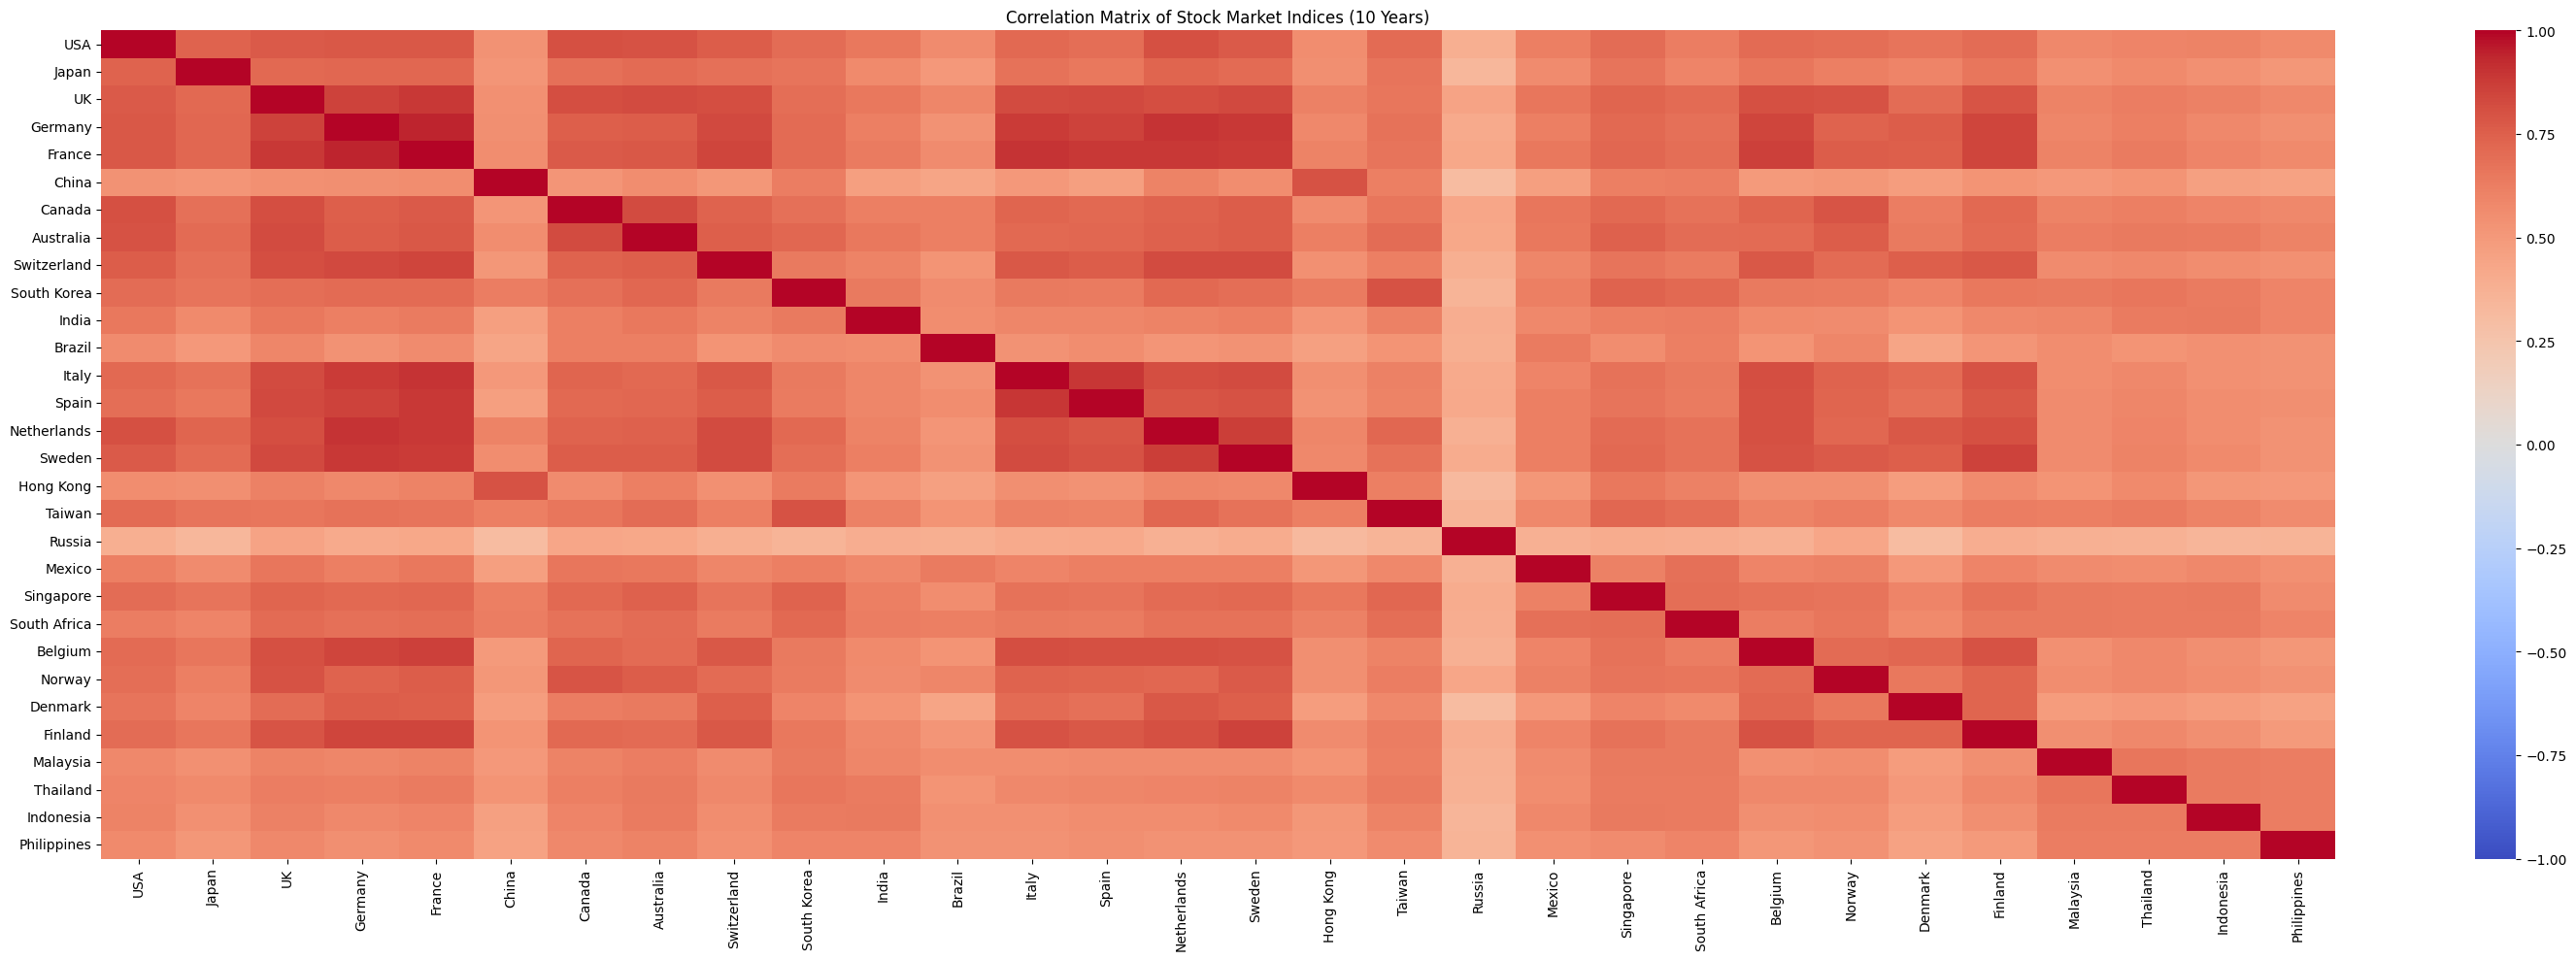

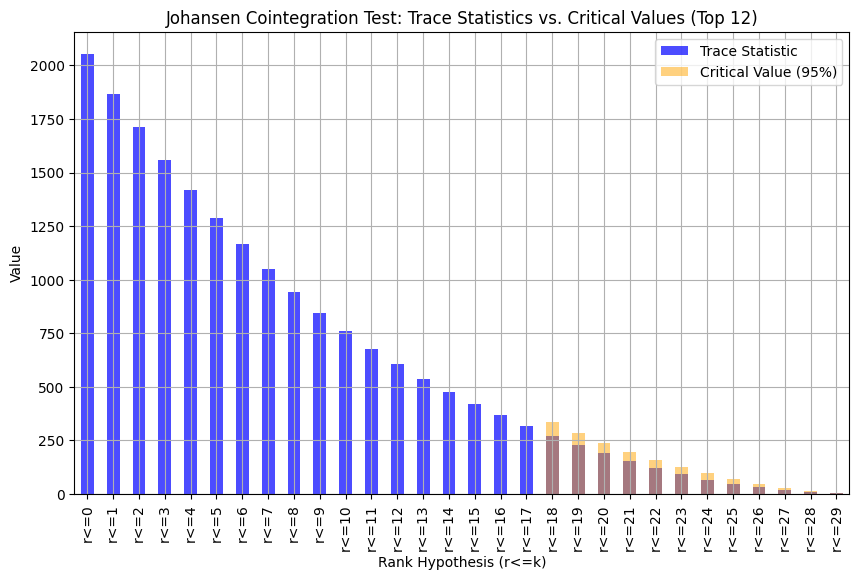


Ranking by Correlation with USA (VOO):
USA             1.000000
Netherlands     0.807963
Canada          0.806764
Australia       0.798088
Germany         0.776511
France          0.774852
UK              0.771704
Sweden          0.769039
Switzerland     0.763822
Japan           0.741542
Italy           0.715355
Belgium         0.708980
Taiwan          0.705109
South Korea     0.700492
Finland         0.699762
Singapore       0.697838
Spain           0.695207
Norway          0.691219
Denmark         0.664929
India           0.654687
South Africa    0.628934
Mexico          0.622967
Indonesia       0.608377
Thailand        0.597334
Malaysia        0.579639
Philippines     0.577929
Brazil          0.565365
Hong Kong       0.562295
China           0.533255
Russia          0.390201
Name: USA, dtype: float64

Ranking by Cointegration Strength with USA:
France          0.736331
Norway          0.699278
Denmark         0.590614
Finland         0.581887
Sweden          0.441234
Germany       

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Define top 30 countries' stock market indices
indices = {
    'USA': 'VOO', 'Japan': 'EWJ', 'UK': 'EWU', 'Germany': 'EWG', 'France': 'EWQ',
    'China': 'MCHI', 'Canada': 'EWC', 'Australia': 'EWA', 'Switzerland': 'EWL',
    'South Korea': 'EWY', 'India': 'INDA', 'Brazil': 'EWZ', 'Italy': 'EWI',
    'Spain': 'EWP', 'Netherlands': 'EWN', 'Sweden': 'EWD', 'Hong Kong': 'EWH',
    'Taiwan': 'EWT', 'Russia': 'ERUS', 'Mexico': 'EWW', 'Singapore': 'EWS',
    'South Africa': 'EZA', 'Belgium': 'EWK', 'Norway': 'ENOR', 'Denmark': 'EDEN',
    'Finland': 'EFNL', 'Malaysia': 'EWM', 'Thailand': 'THD', 'Indonesia': 'EIDO',
    'Philippines': 'EPHE'
}

# Function to scrape data
def scrape_index_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for country, ticker in tickers.items():
        try:
            df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)['Close']
            if not df.empty:
                data[country] = df
                print(f"Data retrieved for {country} ({ticker})")
            else:
                print(f"No data for {country} ({ticker})")
        except Exception as e:
            print(f"Error retrieving {country} ({ticker}): {e}")
    return data.dropna(how='all')

# ADF test for stationarity
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"{name} ADF Test p-value: {result[1]:.4f}")
    return result[1] < 0.05

# Analyze correlations and cointegration
def analyze_relationships(data):
    returns = data.pct_change(fill_method=None).dropna()
    correlation_matrix = returns.corr()

    # Top 12 correlated with USA for cointegration
    usa_corrs = correlation_matrix['USA'].drop('USA').sort_values(ascending=False)
    top_30 = usa_corrs.head(30).index.tolist() + ['USA']
    coint_data = data.dropna()

    if coint_data.shape[0] > coint_data.shape[1]:
        johansen_result = coint_johansen(coint_data, det_order=0, k_ar_diff=1)
        trace_stat = johansen_result.lr1
        critical_values = johansen_result.cvt[:, 1]  # 95%
        eigenvectors = johansen_result.evec  # Cointegrating vectors
        coint_results = pd.DataFrame({
            'Trace Statistic': trace_stat,
            'Critical Value (95%)': critical_values
        }, index=[f"r<={i}" for i in range(len(trace_stat))])
        coint_summary = coint_results['Trace Statistic'] > coint_results['Critical Value (95%)']

        # Rank by cointegration strength (absolute eigenvector weights for first relationship)
        coint_rank = pd.Series(np.abs(eigenvectors[:, 0]), index=top_30).sort_values(ascending=False)
    else:
        coint_summary = "Insufficient data"
        coint_results = None
        coint_rank = None

    return correlation_matrix, coint_summary, coint_results, coint_rank

# Visualization and ranking
def visualize_and_rank(correlation_matrix, coint_summary, coint_results, coint_rank):
    # Correlation heatmap
    plt.figure(figsize=(30, 10))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Matrix of Stock Market Indices (10 Years)')
    plt.tight_layout()
    plt.show()

    # Cointegration bar chart
    if isinstance(coint_results, pd.DataFrame):
        plt.figure(figsize=(10, 6))
        coint_results['Trace Statistic'].plot(kind='bar', color='blue', alpha=0.7, label='Trace Statistic')
        coint_results['Critical Value (95%)'].plot(kind='bar', color='orange', alpha=0.5, label='Critical Value (95%)')
        plt.title('Johansen Cointegration Test: Trace Statistics vs. Critical Values (Top 12)')
        plt.xlabel('Rank Hypothesis (r<=k)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()
        plt.show()

    # Print rankings
    print("\nRanking by Correlation with USA (VOO):")
    print(correlation_matrix['USA'].sort_values(ascending=False))

    print("\nRanking by Cointegration Strength with USA:")
    if coint_rank is not None:
        print(coint_rank)
    else:
        print("No cointegration data available")

    print("\nJohansen Cointegration Test Summary:")
    print(coint_summary)

# Main execution
if __name__ == "__main__":
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365 * 10)  # 10 years of data

    print("Retrieving stock market index data...")
    index_data = scrape_index_data(indices, start_date, end_date)

    if index_data.empty:
        print("No data retrieved. Exiting.")
        exit()

    print("\nStationarity Test (ADF) for Price Levels:")
    for column in index_data.columns:
        adf_test(index_data[column], column)

    correlation_matrix, coint_summary, coint_results, coint_rank = analyze_relationships(index_data)
    visualize_and_rank(correlation_matrix, coint_summary, coint_results, coint_rank)